# R3 Q8: Heterogeneity Analysis - Main Paper Method

## Replicating Main Paper's Heterogeneity Approach

This notebook replicates the heterogeneity analysis method used in the main manuscript (line 238, `trajectory_and_prs_cluster.R`):

**Method:**
1. **Cluster by time-averaged signature loadings** (k-means on mean theta across time)
2. **Project deviations from reference** over time for each cluster
3. **Correlate with PRS** to understand genetic differences between clusters

**Key Difference from Deviation-Based Method:**
- **This method (main paper)**: Clusters patients based on their average signature levels, then visualizes how each cluster deviates from the population reference over time. More interpretable for clinical applications.
- **Deviation-based method** (R3_Q8_Heterogeneity_Continued): Clusters patients based on how their trajectories deviate from the population average. Better for pathway discovery.

Both approaches demonstrate heterogeneity, but serve different purposes.


## Note

This notebook replicates the exact method from the main paper (`trajectory_and_prs_cluster.R`, line 70-364). For a complete implementation, see the helper script that will be created. This notebook provides the framework and key visualizations.


In [1]:
# ============================================================================
# SETUP: Import and Configure
# ============================================================================
import sys
import os
%load_ext autoreload
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/')

from helper_py.pathway_discovery import load_full_data
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("="*80)
print("HETEROGENEITY ANALYSIS: MAIN PAPER METHOD")
print("="*80)
print("\nThis notebook replicates the method from trajectory_and_prs_cluster.R")
print("Method: Cluster by time-averaged signature loadings, then visualize")
print("        deviations from reference over time and correlate with PRS")
print("="*80)


HETEROGENEITY ANALYSIS: MAIN PAPER METHOD

This notebook replicates the method from trajectory_and_prs_cluster.R
Method: Cluster by time-averaged signature loadings, then visualize
        deviations from reference over time and correlate with PRS


## Load Data

Load thetas, Y matrix, disease names, processed IDs, PRS, and reference trajectories.


In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================

# Load full data (Y, thetas, disease_names, processed_ids)
Y, thetas, disease_names, processed_ids = load_full_data()

# Calculate time-averaged thetas (mean across time dimension)
# This is what we cluster on in the main paper method
time_averaged_theta = thetas.mean(axis=2)
print(f"\n✅ Time-averaged theta shape: {time_averaged_theta.shape} (patients × signatures)")

# Load PRS data
prs_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/csv/prs_with_eid.csv')
print(f"\nLoading PRS data from: {prs_path}")
prs_df = pd.read_csv(prs_path)
prs_cols = [col for col in prs_df.columns if col != 'PatientID']
print(f"✅ PRS shape: {prs_df.shape}")
print(f"✅ PRS columns: {len(prs_cols)} PRS scores")

# Load reference trajectories (sig_refs)
sig_refs_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/csv/reference_thetas.csv')
print(f"\nLoading reference trajectories from: {sig_refs_path}")
sig_refs = pd.read_csv(sig_refs_path, header=0)
sig_refs = sig_refs.values  # Convert to numpy array (K × T)
print(f"✅ Reference trajectories shape: {sig_refs.shape} (signatures × timepoints)")

print("\n" + "="*80)
print("✅ DATA LOADING COMPLETE")
print("="*80)


Loading full dataset...
Loaded Y (full): torch.Size([407878, 348, 52])
Loaded thetas: (400000, 21, 52)
Loaded 400000 processed IDs
Subset Y to first 400K patients: torch.Size([400000, 348, 52])
Loaded 348 diseases
Total patients with complete data: 400000

✅ Time-averaged theta shape: (400000, 21) (patients × signatures)

Loading PRS data from: /Users/sarahurbut/aladynoulli2/pyScripts/csv/prs_with_eid.csv
✅ PRS shape: (400000, 37)
✅ PRS columns: 36 PRS scores

Loading reference trajectories from: /Users/sarahurbut/aladynoulli2/pyScripts/csv/reference_thetas.csv
✅ Reference trajectories shape: (21, 52) (signatures × timepoints)

✅ DATA LOADING COMPLETE


## Analysis: Main Paper Method

This replicates `traj_func` from `trajectory_and_prs_cluster.R`:

1. **Identify diseased patients** for target disease
2. **Cluster by time-averaged signature loadings** (k-means, k=3)
3. **Calculate deviations from reference** over time for each cluster
4. **Correlate with PRS** (mean PRS per cluster, Cohen's d)

**Diseases analyzed:**
- Myocardial infarction
- Malignant neoplasm of female breast

This will create all visualizations for both diseases.


In [3]:
# ============================================================================
# ANALYSIS FUNCTION: Run for a single disease
# ============================================================================

def analyze_disease_heterogeneity(target_disease, Y, thetas, time_averaged_theta, disease_names, 
                                  processed_ids, prs_df, prs_cols, sig_refs, n_clusters=3, random_state=42):
    """
    Analyze heterogeneity for a single disease using main paper method.
    Returns a dictionary with all results.
    """
    print("\n" + "="*80)
    print(f"ANALYZING: {target_disease}")
    print("="*80)
    
    # Find disease index
    try:
        disease_ix = disease_names.index(target_disease)
        print(f"✅ Found '{target_disease}' at index {disease_ix}")
    except ValueError:
        print(f"❌ Disease '{target_disease}' not found")
        print(f"Available diseases (first 10): {disease_names[:10]}")
        return None
    
    # Identify diseased patients (any timepoint)
    diseased = np.where(Y[:, disease_ix, :].sum(axis=1) > 0)[0]
    print(f"✅ Diseased patients: {len(diseased):,}")
    
    if len(diseased) < n_clusters:
        print(f"❌ Not enough patients for {n_clusters} clusters")
        return None
    
    # Get time-averaged theta for diseased patients
    time_averaged_theta_diseased = time_averaged_theta[diseased, :]
    print(f"✅ Time-averaged theta (diseased): {time_averaged_theta_diseased.shape}")
    
    # Cluster by time-averaged signature loadings (k-means, k=3)
    print(f"\n🔍 Clustering by time-averaged signature loadings (k={n_clusters})...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(time_averaged_theta_diseased)
    
    print(f"✅ Cluster sizes: {np.bincount(clusters + 1)}")
    
    # Calculate deviations from reference over time for each cluster
    K = thetas.shape[1]  # Number of signatures
    T = thetas.shape[2]  # Number of timepoints
    
    time_diff_by_cluster = np.zeros((n_clusters, K, T))
    time_means_by_cluster = np.zeros((n_clusters, K, T))
    
    print(f"\n📊 Calculating deviations from reference over time...")
    for t in range(T):
        # Get theta for this timepoint for diseased patients
        time_spec_theta = thetas[diseased, :, t]  # N_d × K
        
        # Calculate mean theta per cluster for this timepoint
        for c in range(n_clusters):
            cluster_mask = clusters == c
            if cluster_mask.sum() > 0:
                time_means_by_cluster[c, :, t] = time_spec_theta[cluster_mask, :].mean(axis=0)
                # Deviation from reference
                time_diff_by_cluster[c, :, t] = time_means_by_cluster[c, :, t] - sig_refs[:, t]
    
    print(f"✅ Calculated deviations for {n_clusters} clusters × {K} signatures × {T} timepoints")
    
    # Load PRS for diseased patients
    print(f"\n🧬 Loading PRS data for diseased patients...")
    diseased_eids = processed_ids[diseased]
    
    # Match PRS to diseased patients by eid
    eid_to_prs_idx = {eid: idx for idx, eid in enumerate(prs_df['PatientID'].values)}
    prs_matrix = np.zeros((len(diseased), len(prs_cols)))
    prs_mask = np.zeros(len(diseased), dtype=bool)
    
    for i, eid in enumerate(diseased_eids):
        if eid in eid_to_prs_idx:
            prs_idx = eid_to_prs_idx[eid]
            prs_matrix[i, :] = prs_df.iloc[prs_idx][prs_cols].values
            prs_mask[i] = True
    
    print(f"✅ PRS data available for {prs_mask.sum():,} / {len(diseased):,} patients")
    print(f"✅ PRS matrix shape: {prs_matrix.shape}")
    
    # Calculate PRS means by cluster
    print(f"\n📈 Calculating PRS means by cluster...")
    prs_means_by_cluster = {}
    for c in range(n_clusters):
        cluster_mask = clusters == c
        cluster_with_prs = cluster_mask & prs_mask
        if cluster_with_prs.sum() > 0:
            prs_means_by_cluster[c] = prs_matrix[cluster_with_prs, :].mean(axis=0)
            print(f"   Cluster {c+1}: {cluster_with_prs.sum():,} patients with PRS")
        else:
            prs_means_by_cluster[c] = np.zeros(len(prs_cols))
    
    return {
        'disease_name': target_disease,
        'disease_ix': disease_ix,
        'n_diseased': len(diseased),
        'diseased': diseased,
        'clusters': clusters,
        'time_diff_by_cluster': time_diff_by_cluster,
        'time_means_by_cluster': time_means_by_cluster,
        'time_averaged_theta_diseased': time_averaged_theta_diseased,
        'prs_matrix': prs_matrix,
        'prs_mask': prs_mask,
        'prs_means_by_cluster': prs_means_by_cluster,
        'K': K,
        'T': T,
        'n_clusters': n_clusters
    }

# ============================================================================
# RUN ANALYSIS FOR BOTH DISEASES
# ============================================================================

target_diseases = ["Myocardial infarction", "Malignant neoplasm of female breast","Major depressive disorder"]
results_dict = {}

for target_disease in target_diseases:
    results = analyze_disease_heterogeneity(
        target_disease=target_disease,
        Y=Y,
        thetas=thetas,
        time_averaged_theta=time_averaged_theta,
        disease_names=disease_names,
        processed_ids=processed_ids,
        prs_df=prs_df,
        prs_cols=prs_cols,
        sig_refs=sig_refs,
        n_clusters=3,
        random_state=42
    )
    
    if results:
        results_dict[target_disease] = results

print("\n" + "="*80)
print("✅ ALL ANALYSES COMPLETE")
print("="*80)


ANALYZING: Myocardial infarction
✅ Found 'Myocardial infarction' at index 112
✅ Diseased patients: 24,920
✅ Time-averaged theta (diseased): (24920, 21)

🔍 Clustering by time-averaged signature loadings (k=3)...
✅ Cluster sizes: [    0  6775  7655 10490]

📊 Calculating deviations from reference over time...
✅ Calculated deviations for 3 clusters × 21 signatures × 52 timepoints

🧬 Loading PRS data for diseased patients...
✅ PRS data available for 24,920 / 24,920 patients
✅ PRS matrix shape: (24920, 36)

📈 Calculating PRS means by cluster...
   Cluster 1: 6,775 patients with PRS
   Cluster 2: 7,655 patients with PRS
   Cluster 3: 10,490 patients with PRS

ANALYZING: Malignant neoplasm of female breast
✅ Found 'Malignant neoplasm of female breast' at index 17
✅ Diseased patients: 17,302
✅ Time-averaged theta (diseased): (17302, 21)

🔍 Clustering by time-averaged signature loadings (k=3)...
✅ Cluster sizes: [    0  1419  5716 10167]

📊 Calculating deviations from reference over time...
✅ C

In [4]:
# Analysis for both diseases is now in cell 6
# This cell is kept for compatibility but is no longer needed
pass


## Visualizations

Create the plots from the main paper method:
1. Stacked area plot of deviations from reference over time
2. Signature Cohen's d heatmap
3. PRS heatmap by cluster



Creating stacked area plot for: Myocardial infarction
✅ Saved: heterogeneity_main_paper_output/stacked_deviations_Myocardial_infarction.pdf


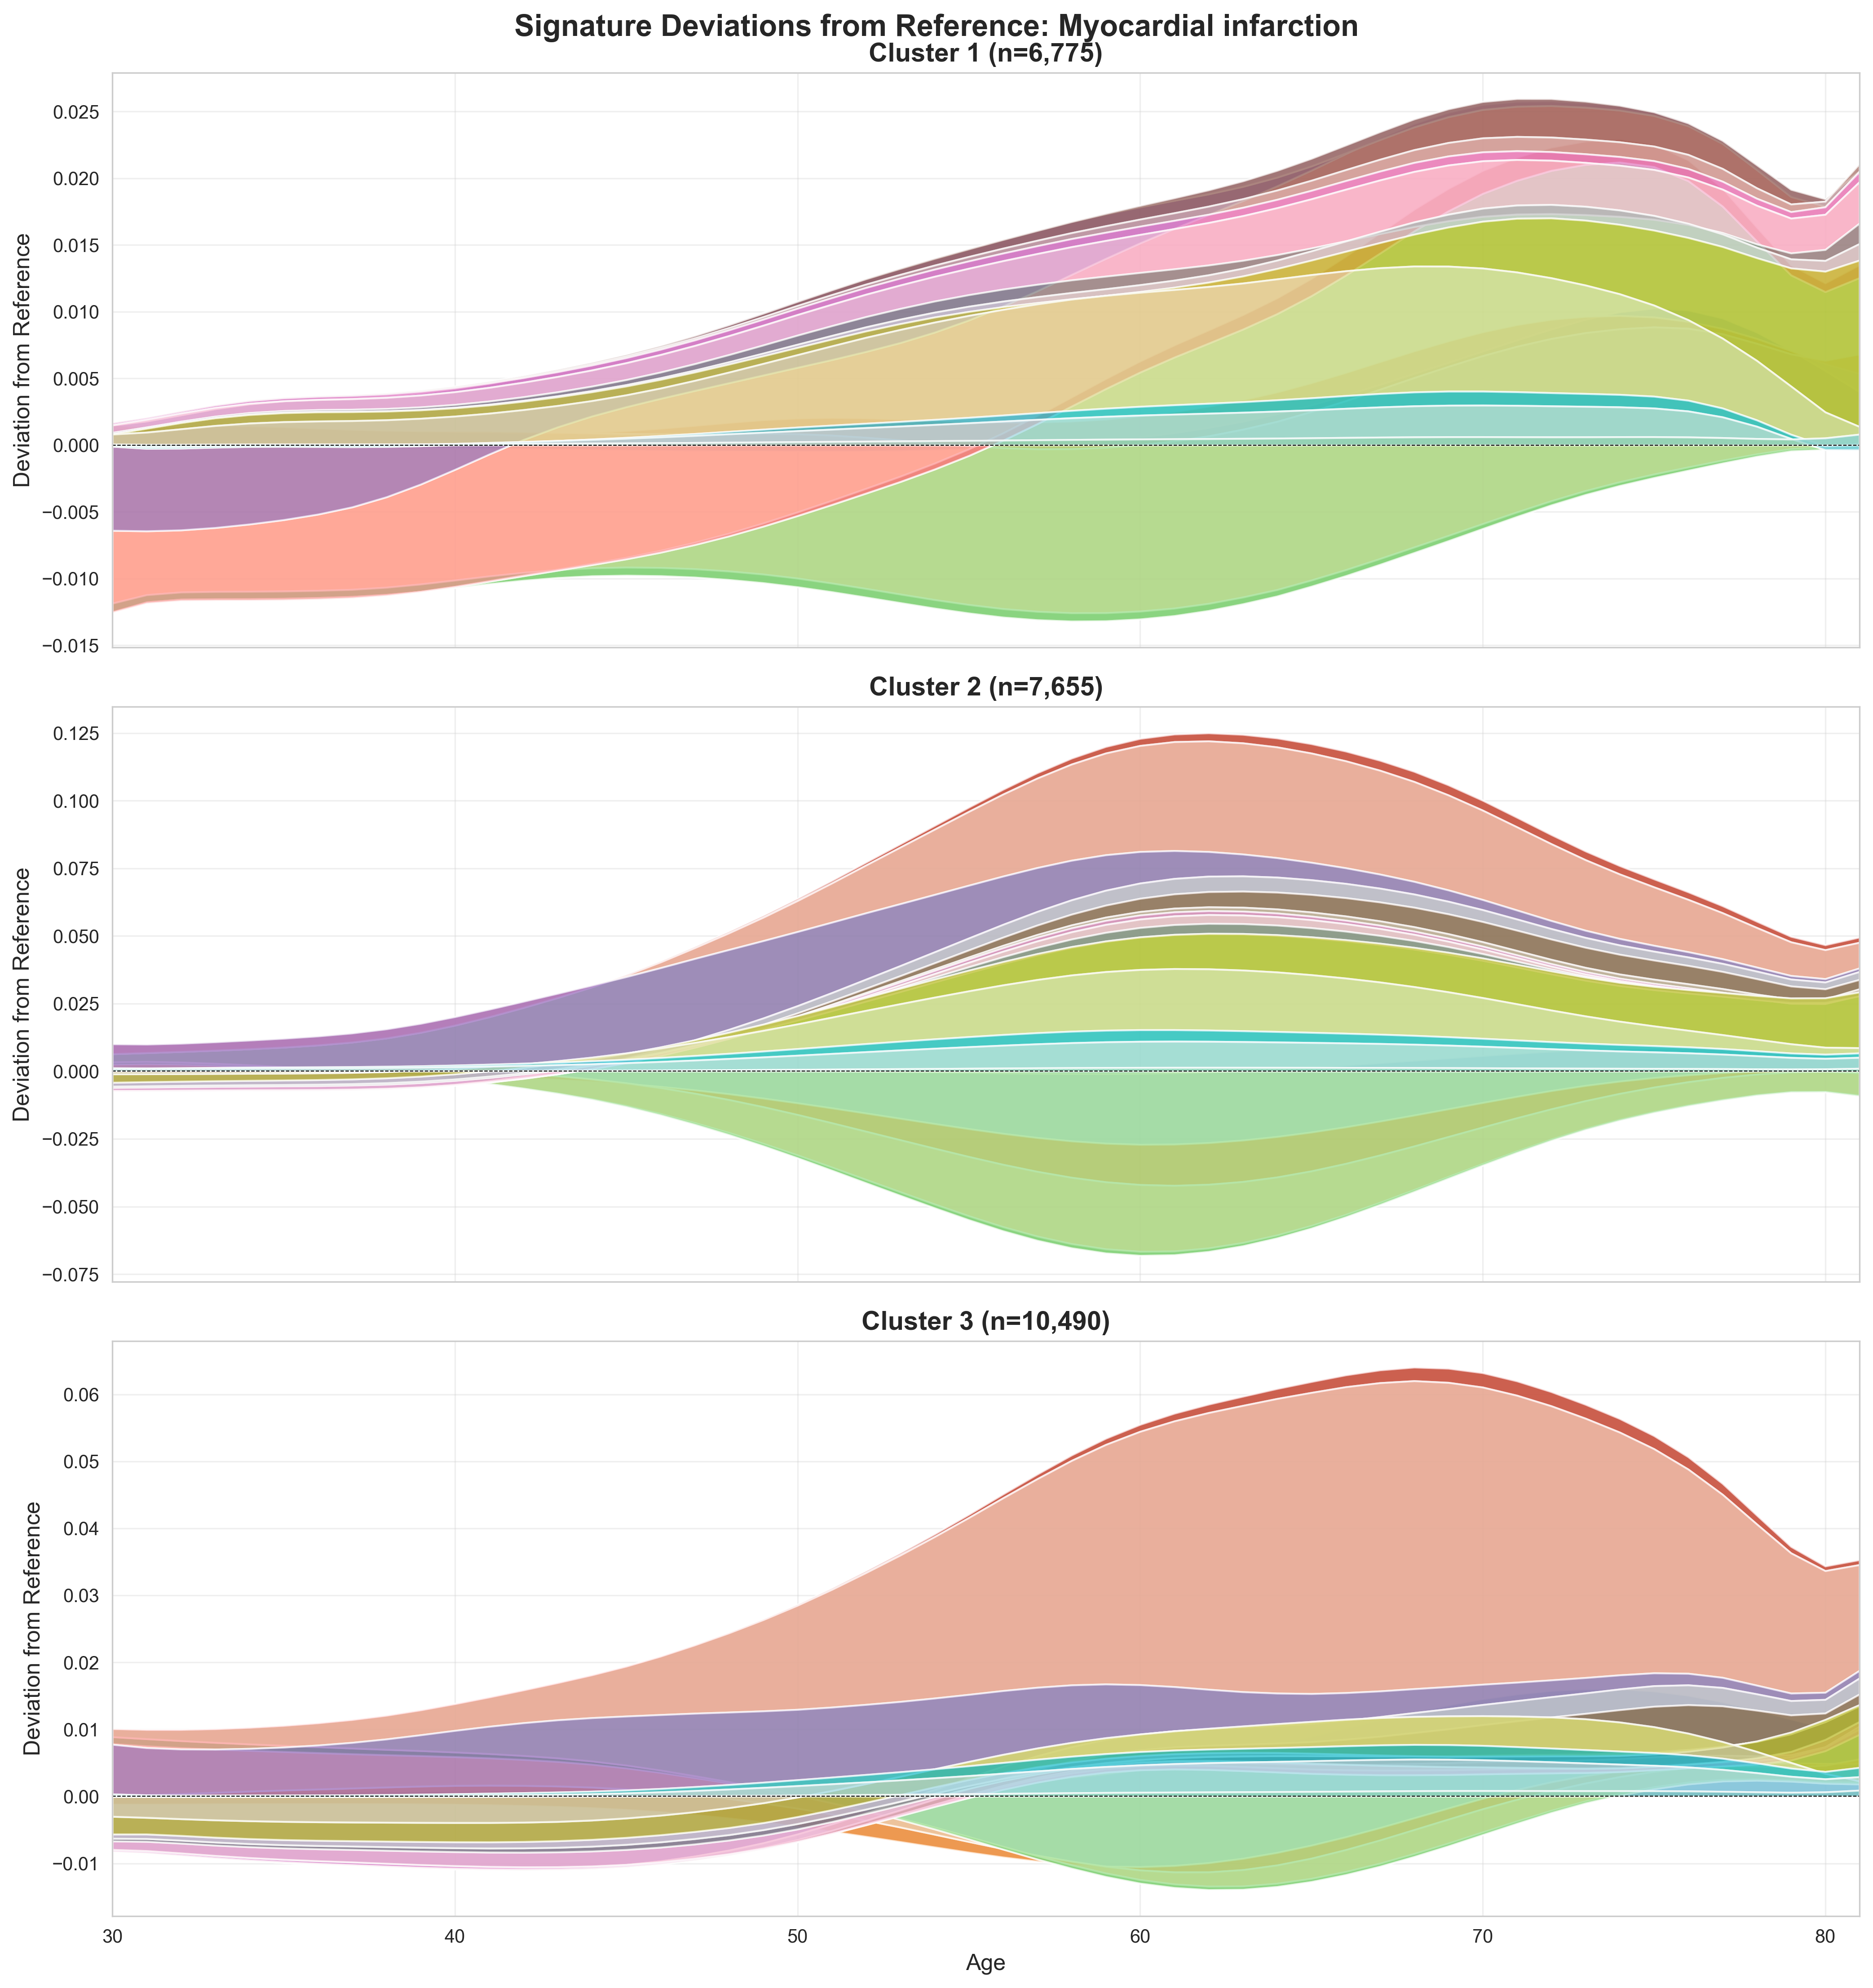


Creating stacked area plot for: Malignant neoplasm of female breast
✅ Saved: heterogeneity_main_paper_output/stacked_deviations_Malignant_neoplasm_of_female_breast.pdf


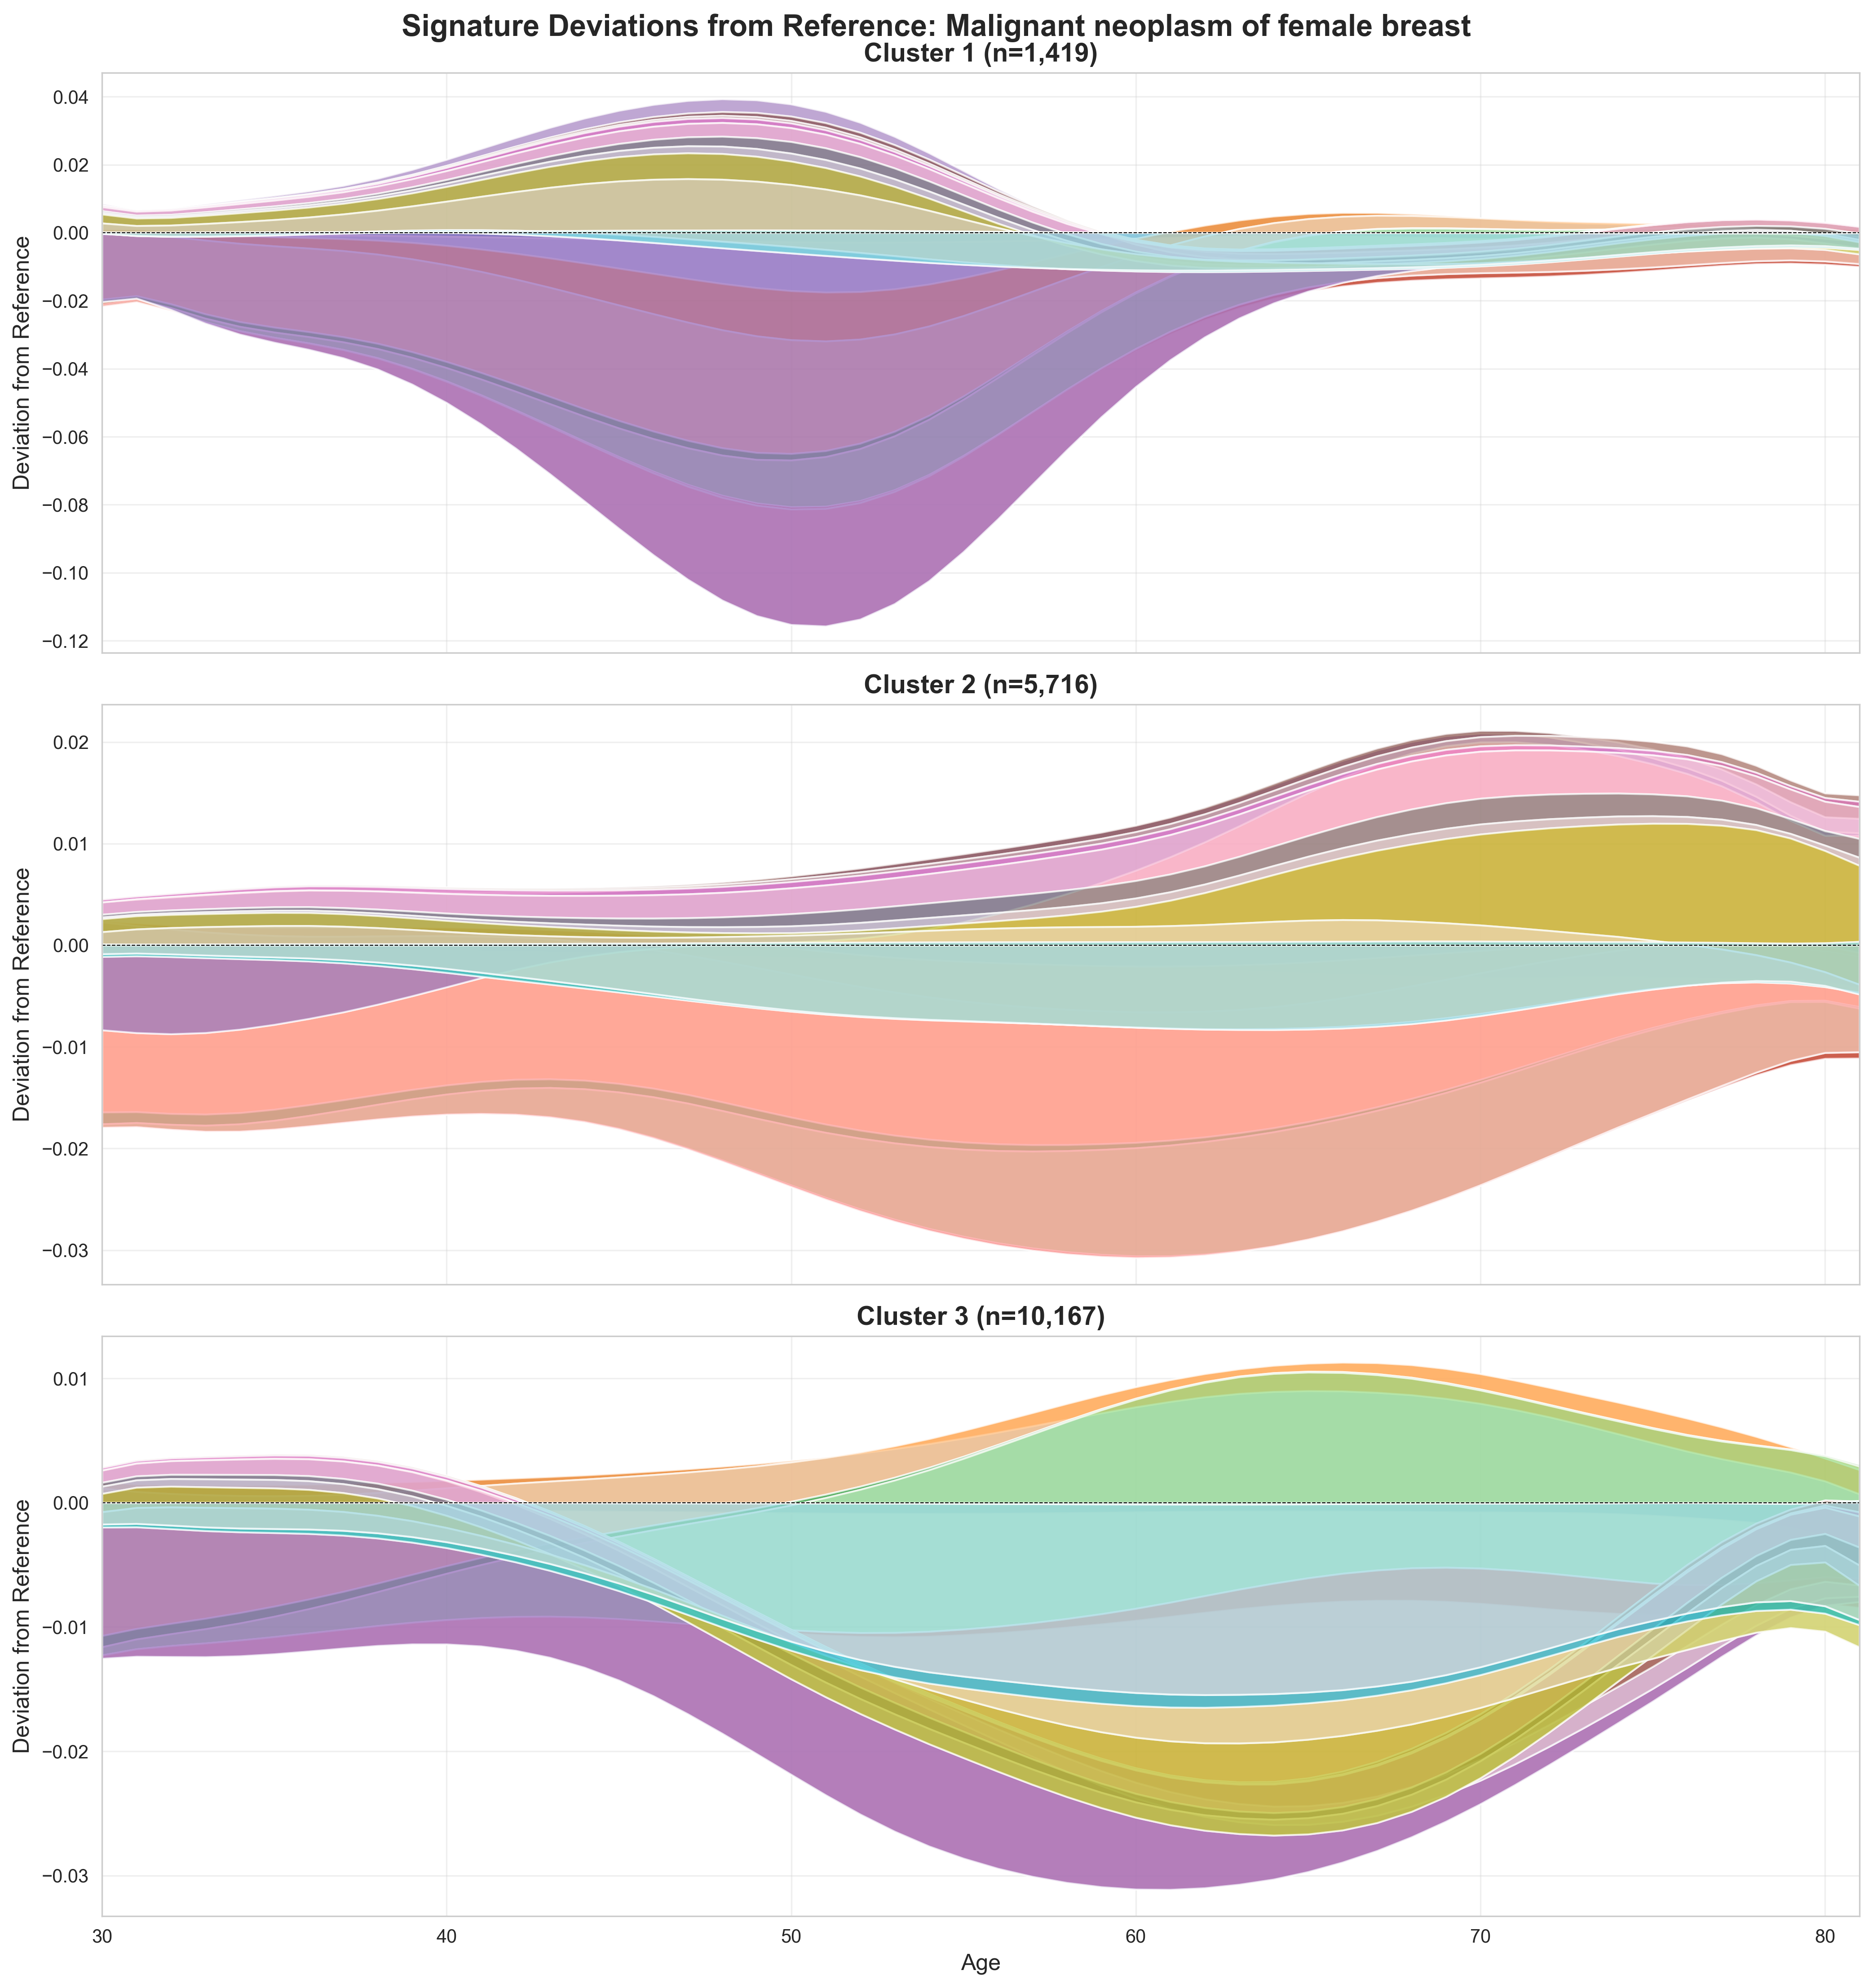


Creating stacked area plot for: Major depressive disorder
✅ Saved: heterogeneity_main_paper_output/stacked_deviations_Major_depressive_disorder.pdf


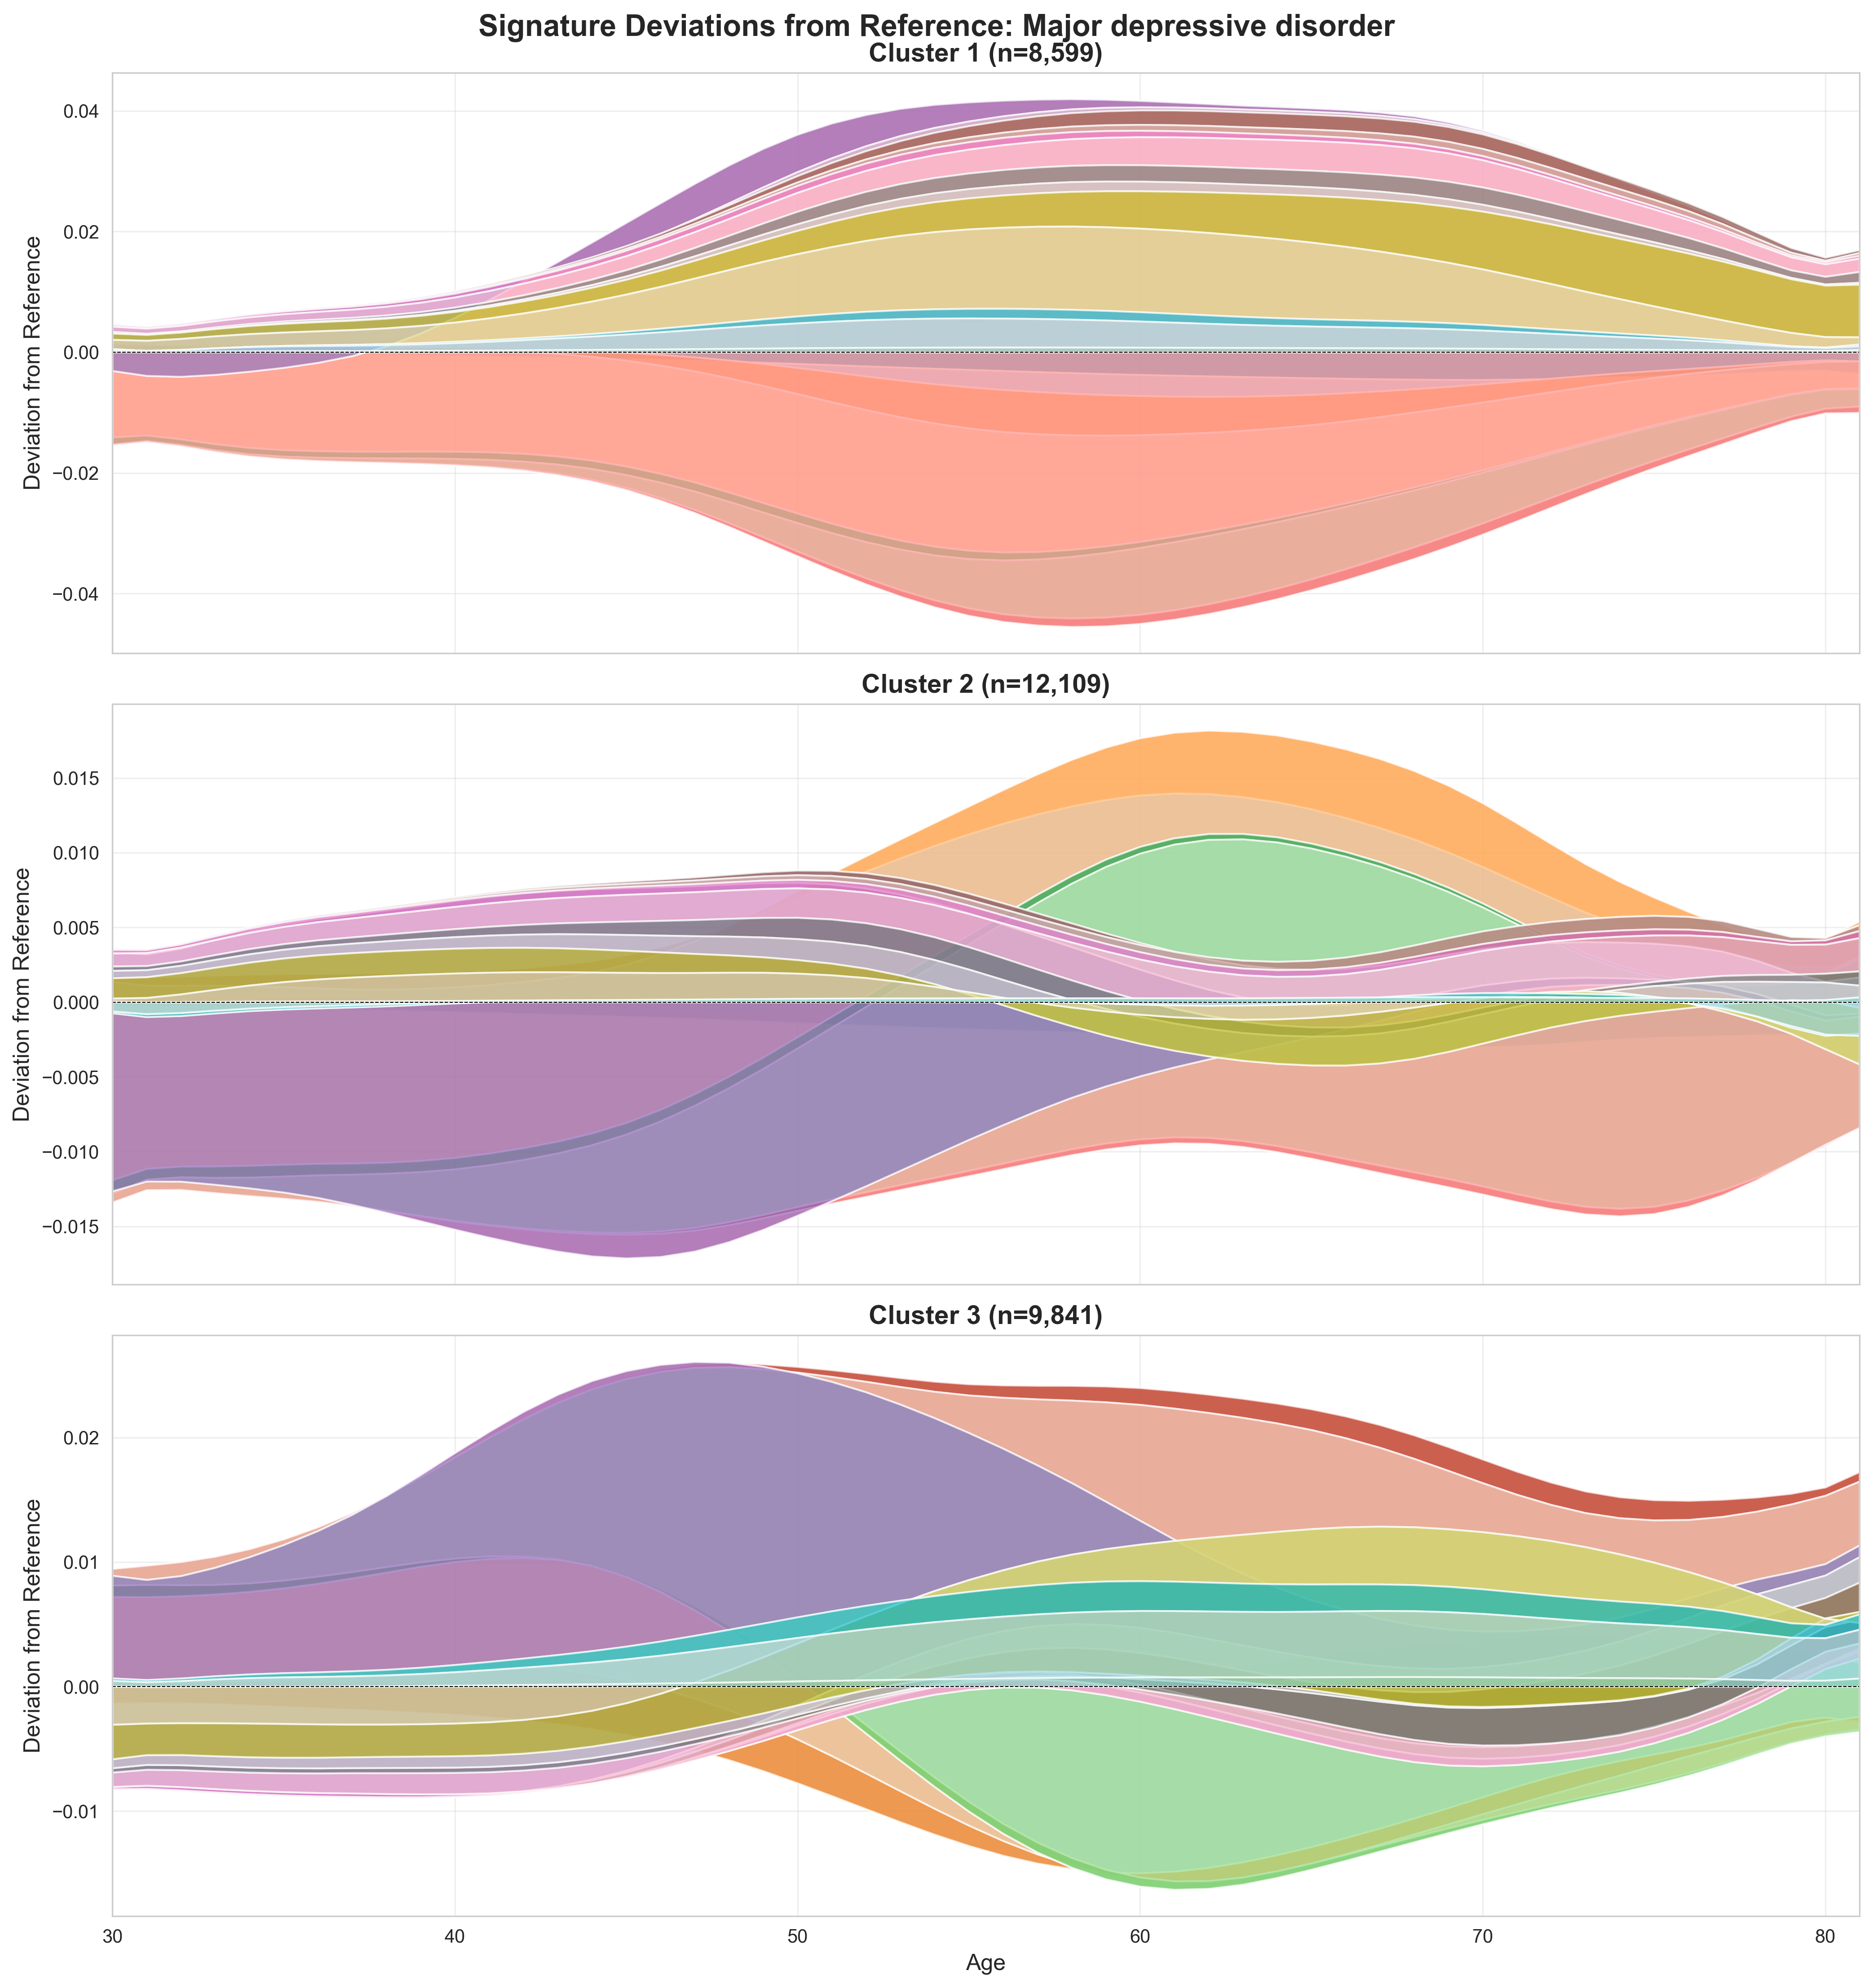

In [5]:
# ============================================================================
# PLOT 1: Stacked Area Plot of Deviations from Reference
# ============================================================================
# This replicates the stacked area plot from trajectory_and_prs_cluster.R (p1)

output_dir = 'heterogeneity_main_paper_output'
os.makedirs(output_dir, exist_ok=True)

# Color palette for signatures (21 signatures)
colors = plt.cm.tab20(np.linspace(0, 1, 20))
colors = np.vstack([colors, plt.cm.Set3(np.linspace(0, 1, 1))])  # Add one more color

for target_disease, results in results_dict.items():
    print(f"\n{'='*80}")
    print(f"Creating stacked area plot for: {target_disease}")
    print(f"{'='*80}")
    
    time_diff_by_cluster = results['time_diff_by_cluster']
    clusters = results['clusters']
    K = results['K']
    T = results['T']
    n_clusters = results['n_clusters']
    
    # Reshape time_diff_by_cluster for plotting
    plot_data = []
    ages = np.arange(30, 30 + T)  # Age = timepoint + 30
    
    for c in range(n_clusters):
        for k in range(K):
            for t in range(T):
                plot_data.append({
                    'Cluster': c + 1,
                    'Signature': k,
                    'Age': ages[t],
                    'Deviation': time_diff_by_cluster[c, k, t]
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create stacked area plot (one subplot per cluster)
    fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 5 * n_clusters), sharex=True)
    
    for c in range(n_clusters):
        cluster_data = plot_df[plot_df['Cluster'] == c + 1]
        
        # Pivot for stacked area plot
        pivot_data = cluster_data.pivot_table(
            index='Age',
            columns='Signature',
            values='Deviation',
            aggfunc='mean'
        )
        
        # Stacked area plot
        axes[c].stackplot(
            pivot_data.index,
            *[pivot_data[col] for col in pivot_data.columns],
            labels=[f'Sig {col}' for col in pivot_data.columns],
            alpha=0.7,
            colors=colors[:K]
        )
        
        cluster_size = (clusters == c).sum()
        axes[c].set_title(f'Cluster {c + 1} (n={cluster_size:,})', fontsize=14, fontweight='bold')
        axes[c].set_ylabel('Deviation from Reference', fontsize=12)
        axes[c].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
        axes[c].grid(True, alpha=0.3)
        axes[c].set_xlim(ages[0], ages[-1])
    
    axes[-1].set_xlabel('Age', fontsize=12)
    fig.suptitle(
        f'Signature Deviations from Reference: {target_disease}',
        fontsize=16,
        fontweight='bold'
    )
    plt.tight_layout()
    
    # Save plot
    output_path = os.path.join(output_dir, f'stacked_deviations_{target_disease.replace(" ", "_")}.pdf')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")
    plt.show()



Creating signature Cohen's d heatmap for: Myocardial infarction
✅ Saved: heterogeneity_main_paper_output/signature_cohens_d_Myocardial_infarction.pdf


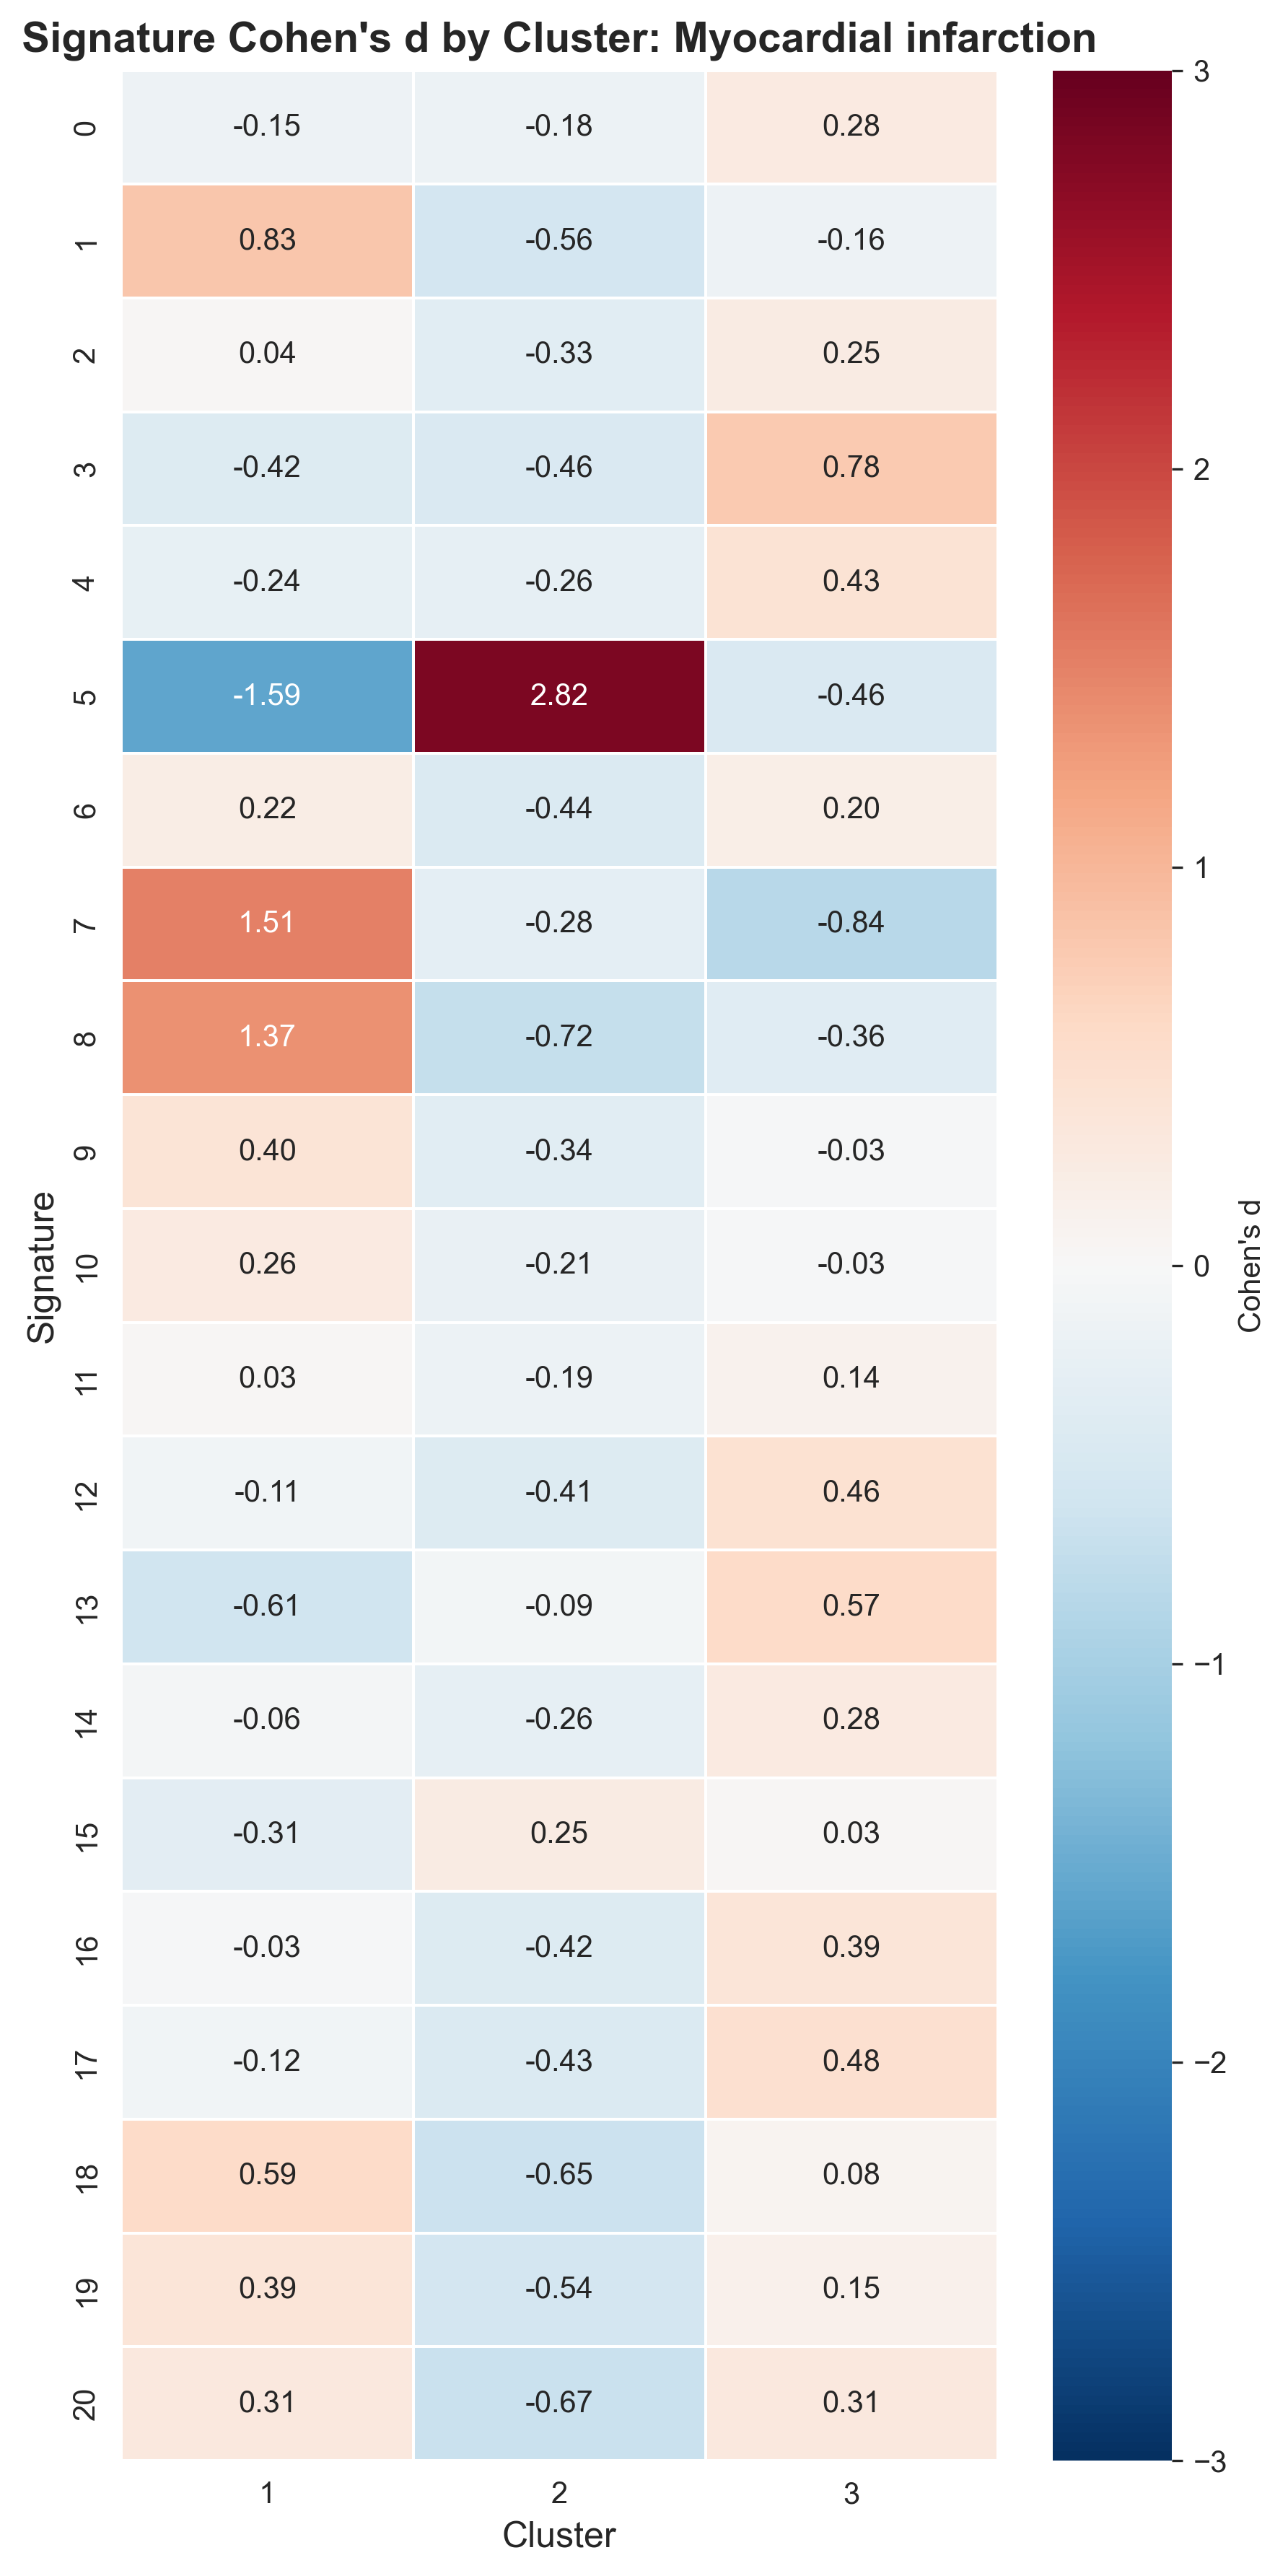

✅ Saved CSV: heterogeneity_main_paper_output/signature_cohens_d_Myocardial_infarction.csv

Creating signature Cohen's d heatmap for: Malignant neoplasm of female breast
✅ Saved: heterogeneity_main_paper_output/signature_cohens_d_Malignant_neoplasm_of_female_breast.pdf


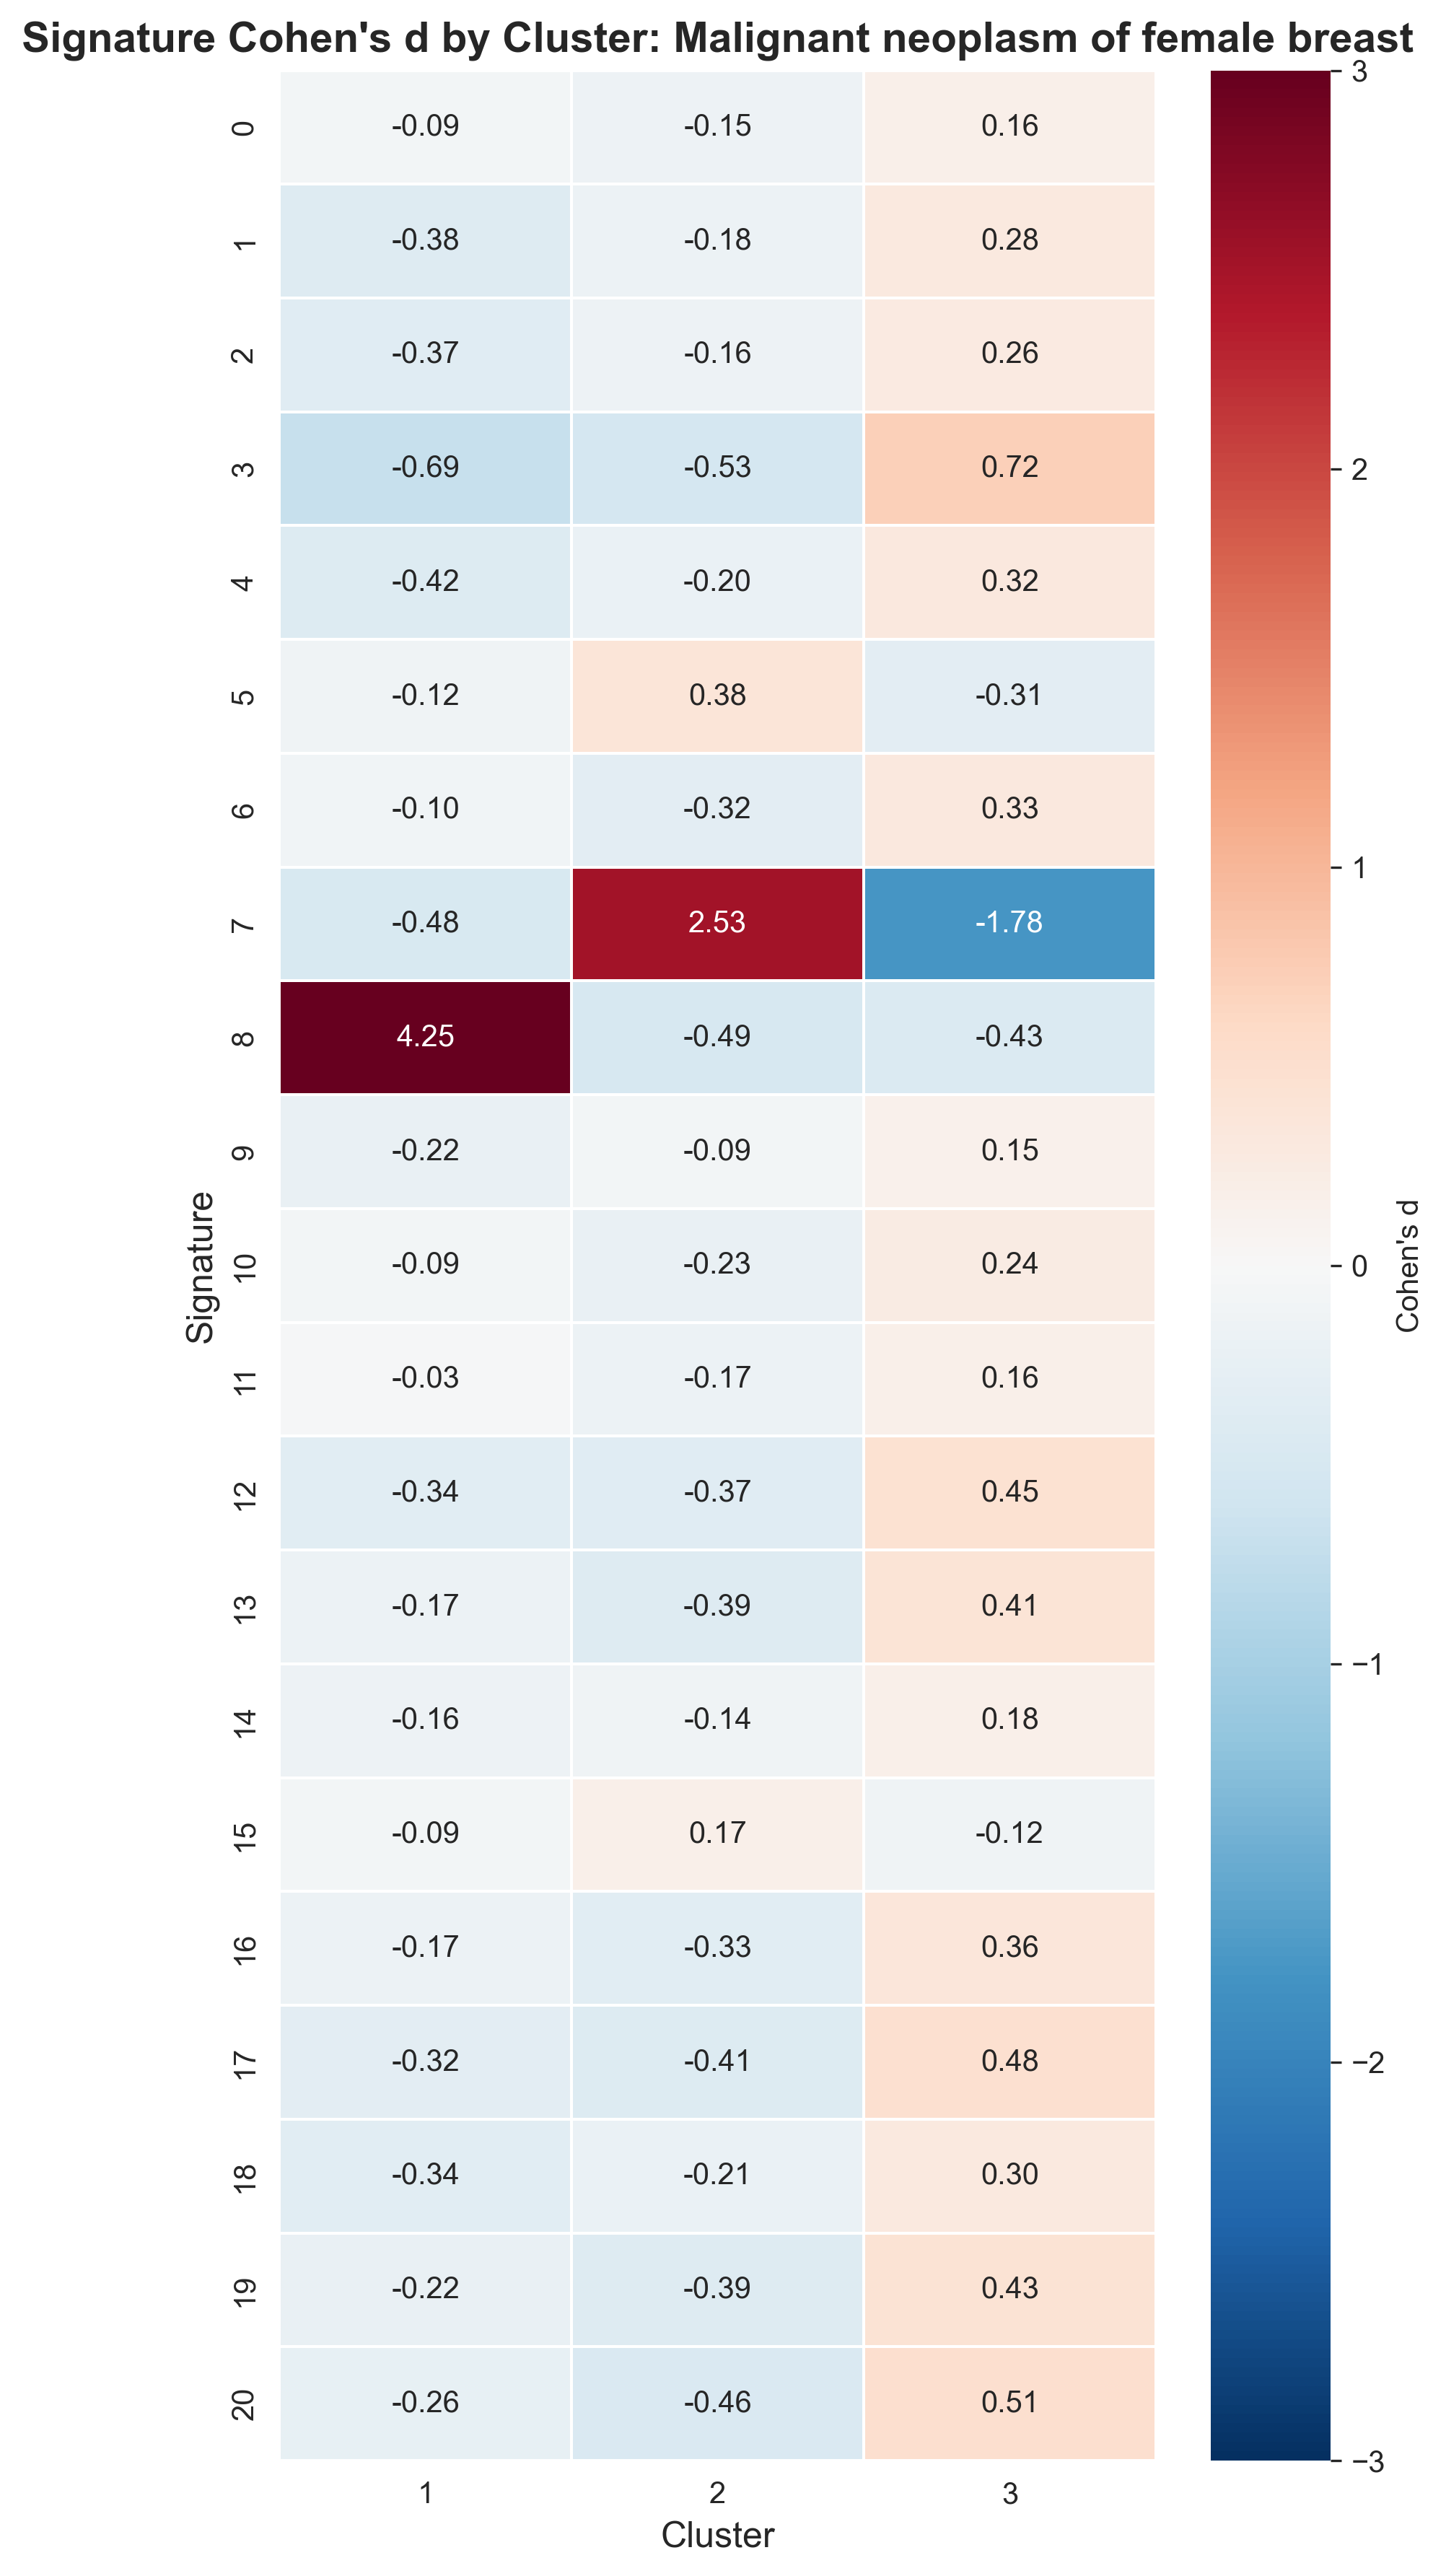

✅ Saved CSV: heterogeneity_main_paper_output/signature_cohens_d_Malignant_neoplasm_of_female_breast.csv

Creating signature Cohen's d heatmap for: Major depressive disorder
✅ Saved: heterogeneity_main_paper_output/signature_cohens_d_Major_depressive_disorder.pdf


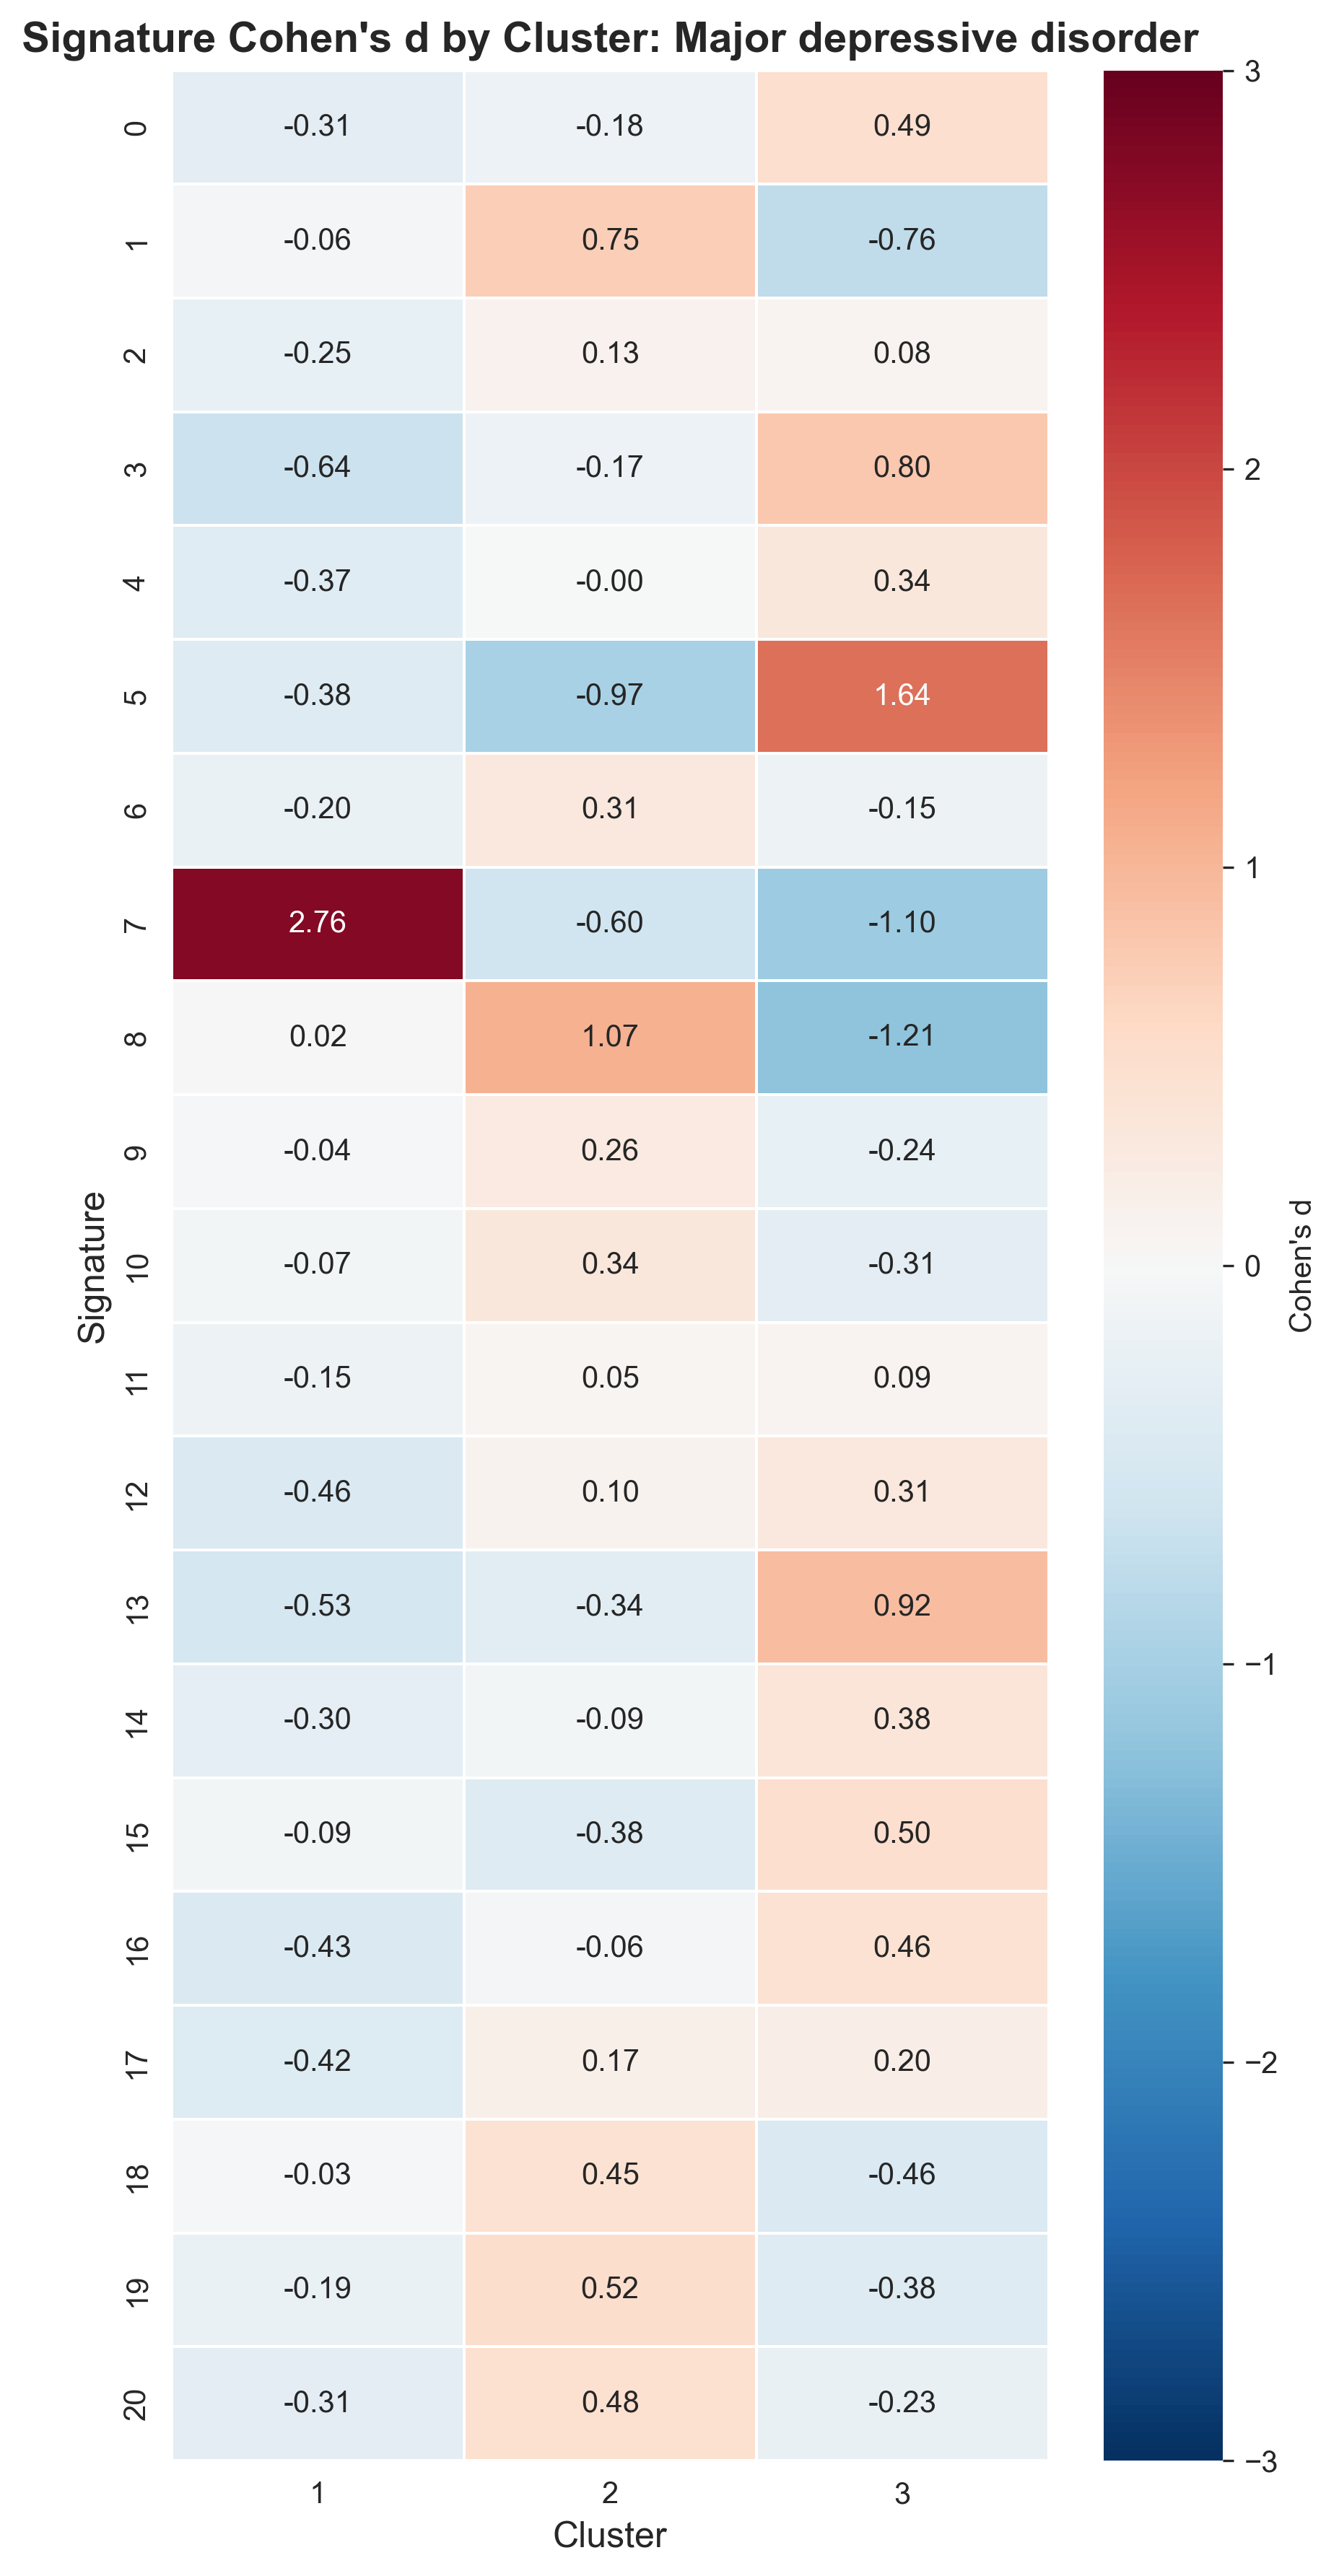

✅ Saved CSV: heterogeneity_main_paper_output/signature_cohens_d_Major_depressive_disorder.csv


In [6]:
# ============================================================================
# PLOT 2: Signature Cohen's d Heatmap
# ============================================================================
# This replicates the signature Cohen's d heatmap from trajectory_and_prs_cluster.R (p_sig)

for target_disease, results in results_dict.items():
    print(f"\n{'='*80}")
    print(f"Creating signature Cohen's d heatmap for: {target_disease}")
    print(f"{'='*80}")
    
    clusters = results['clusters']
    time_averaged_theta_diseased = results['time_averaged_theta_diseased']
    K = results['K']
    n_clusters = results['n_clusters']
    
    # Calculate Cohen's d for signatures
    signature_cohens_d = []
    
    for c in range(n_clusters):
        in_cluster = clusters == c
        out_cluster = clusters != c
        
        for k in range(K):
            mean_in = time_averaged_theta_diseased[in_cluster, k].mean()
            mean_out = time_averaged_theta_diseased[out_cluster, k].mean()
            
            std_in = time_averaged_theta_diseased[in_cluster, k].std()
            std_out = time_averaged_theta_diseased[out_cluster, k].std()
            
            n_in = in_cluster.sum()
            n_out = out_cluster.sum()
            
            # Pooled standard deviation
            pooled_sd = np.sqrt(((n_in - 1) * std_in**2 + (n_out - 1) * std_out**2) / (n_in + n_out - 2))
            
            d = (mean_in - mean_out) / pooled_sd if pooled_sd > 0 else 0
            
            # P-value
            try:
                _, pval = ttest_ind(
                    time_averaged_theta_diseased[in_cluster, k],
                    time_averaged_theta_diseased[out_cluster, k]
                )
            except:
                pval = np.nan
            
            signature_cohens_d.append({
                'Cluster': c + 1,
                'Signature': k,
                'Mean_In': mean_in,
                'Mean_Out': mean_out,
                'Cohen_d': d,
                'p_value': pval
            })
    
    signature_cohens_d_df = pd.DataFrame(signature_cohens_d)
    
    # Create heatmap
    pivot_sig = signature_cohens_d_df.pivot_table(
        index='Signature',
        columns='Cluster',
        values='Cohen_d',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(6, 12))
    
    sns.heatmap(
        pivot_sig,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        vmin=-3,
        vmax=3,
        cbar_kws={'label': "Cohen's d"},
        ax=ax,
        linewidths=0.5
    )
    
    ax.set_title(
        f"Signature Cohen's d by Cluster: {target_disease}",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Signature', fontsize=12)
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, f'signature_cohens_d_{target_disease.replace(" ", "_")}.pdf')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    # Save results
    csv_path = os.path.join(output_dir, f'signature_cohens_d_{target_disease.replace(" ", "_")}.csv')
    signature_cohens_d_df.to_csv(csv_path, index=False)
    print(f"✅ Saved CSV: {csv_path}")



Creating PRS heatmap for: Myocardial infarction
✅ Saved: heterogeneity_main_paper_output/prs_means_Myocardial_infarction.pdf


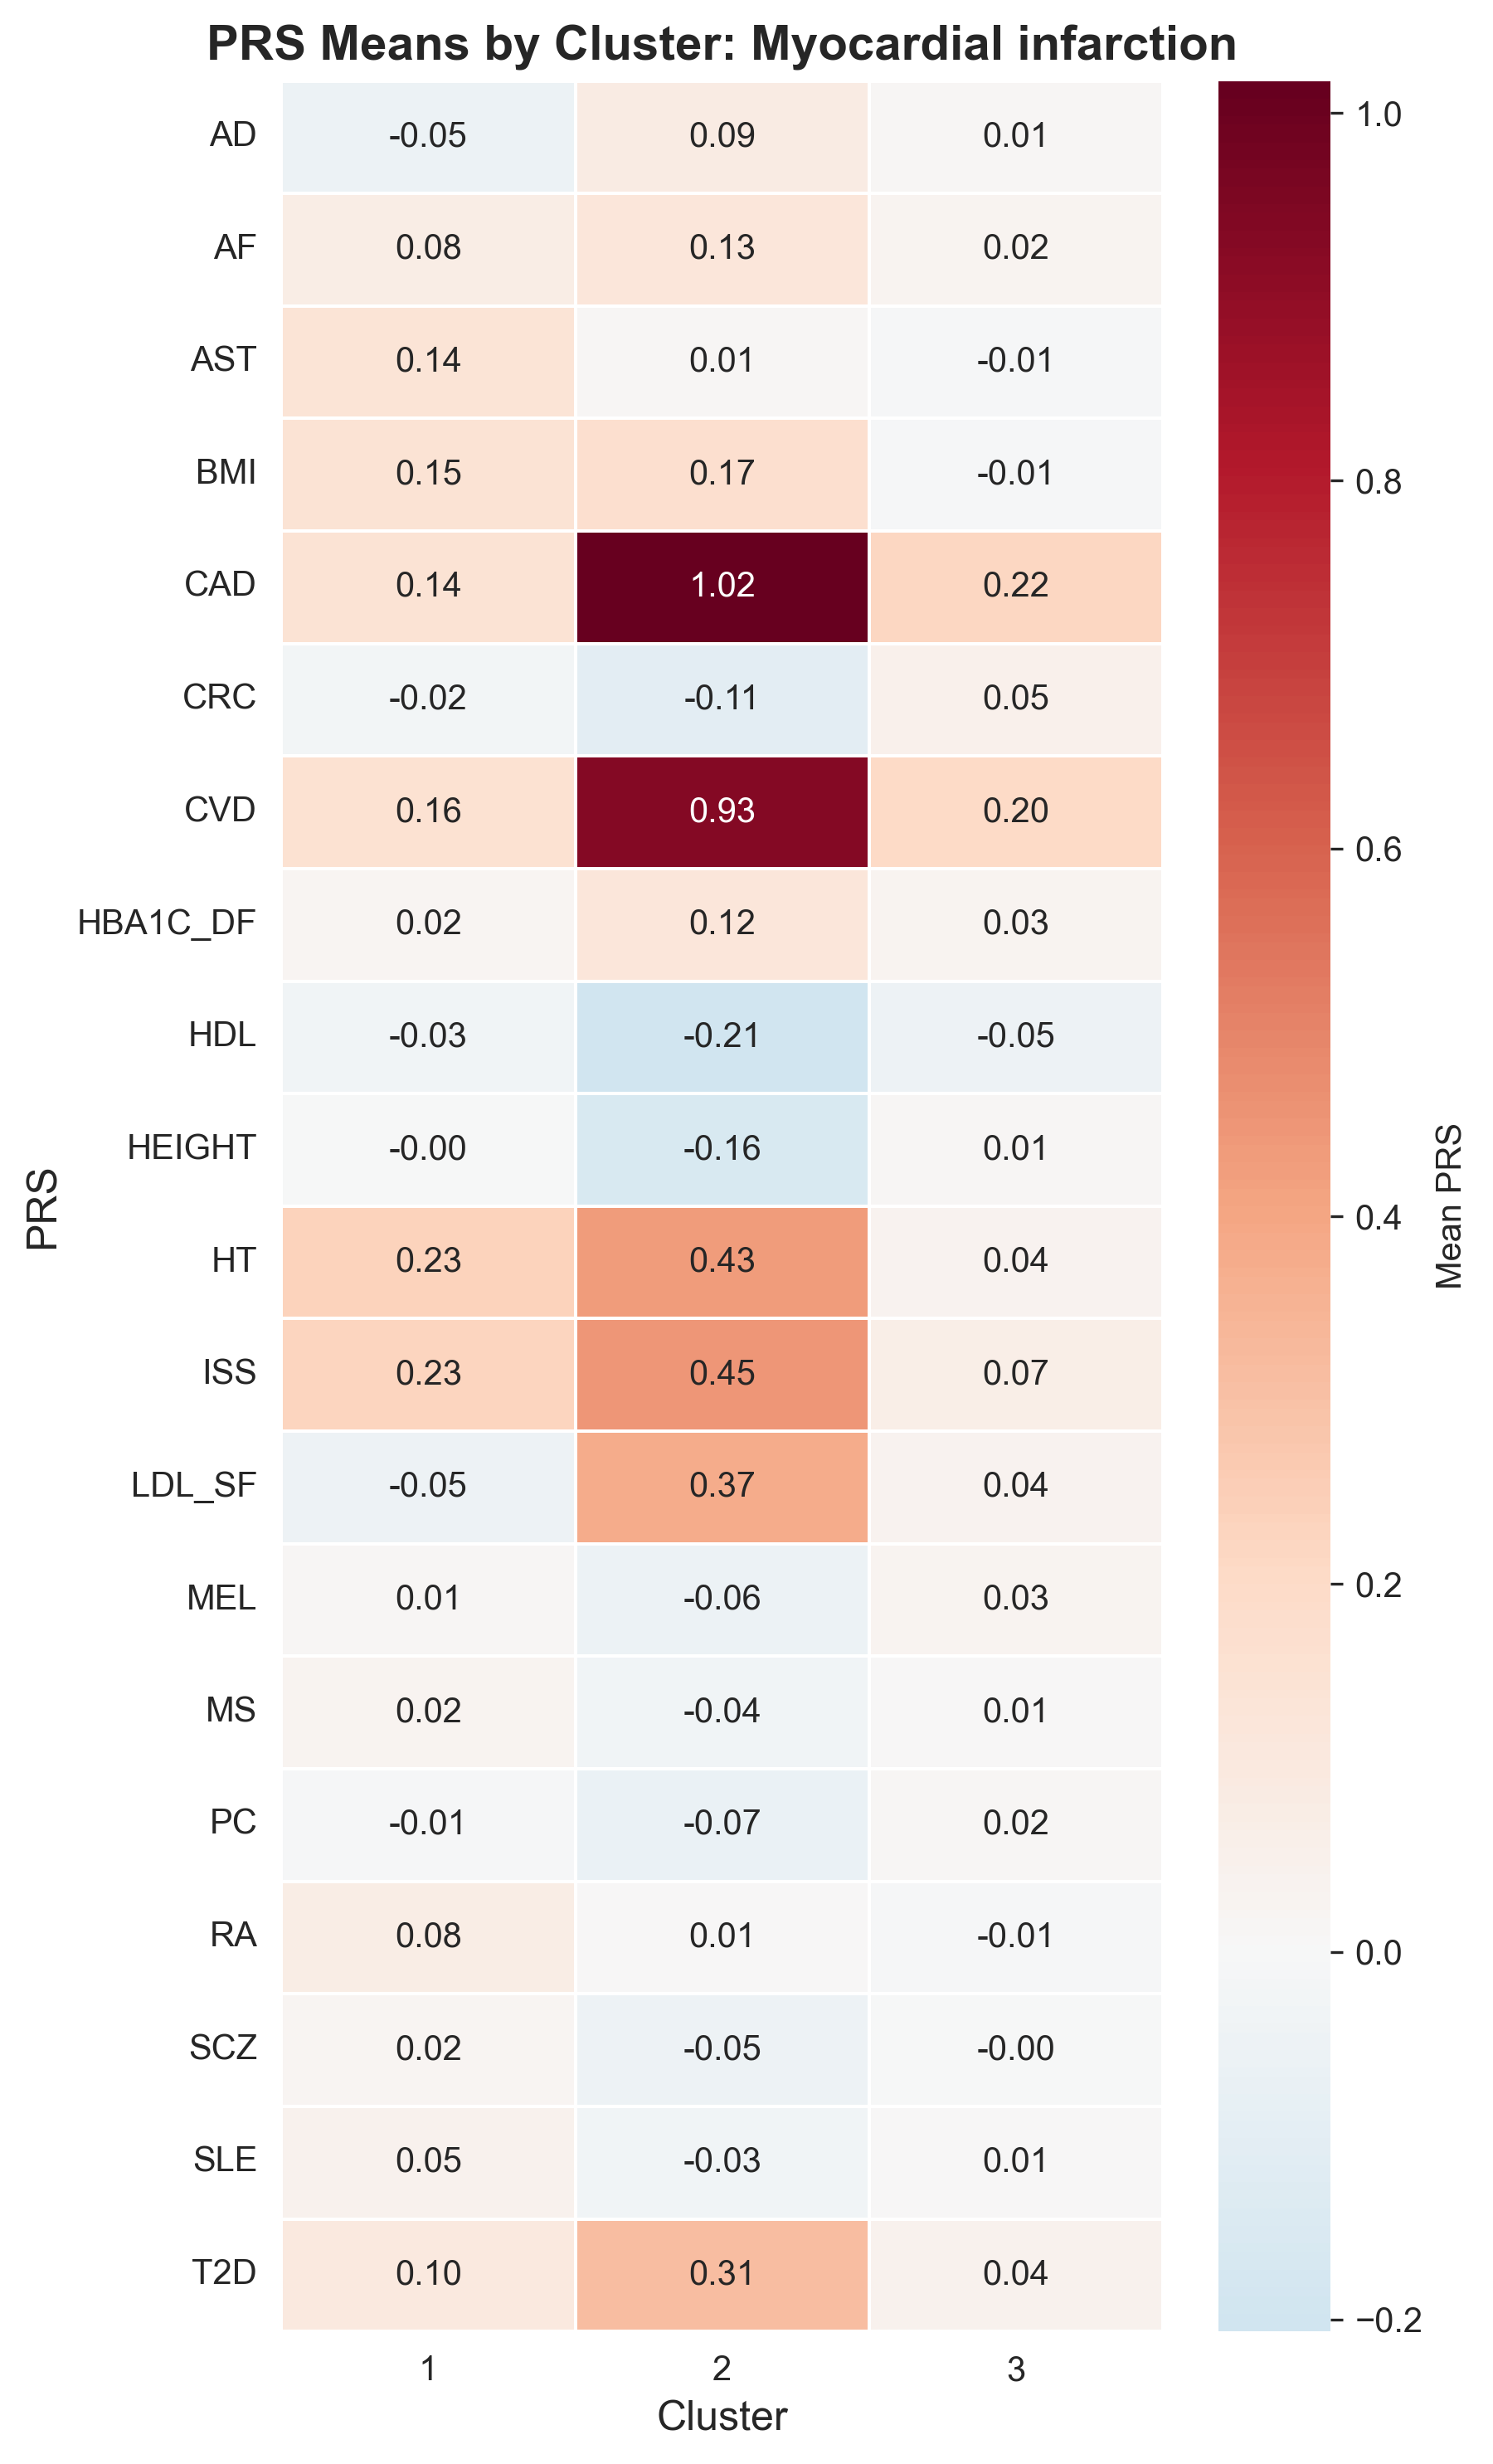

✅ Saved CSV: heterogeneity_main_paper_output/prs_cohens_d_Myocardial_infarction.csv

Creating PRS heatmap for: Malignant neoplasm of female breast
✅ Saved: heterogeneity_main_paper_output/prs_means_Malignant_neoplasm_of_female_breast.pdf


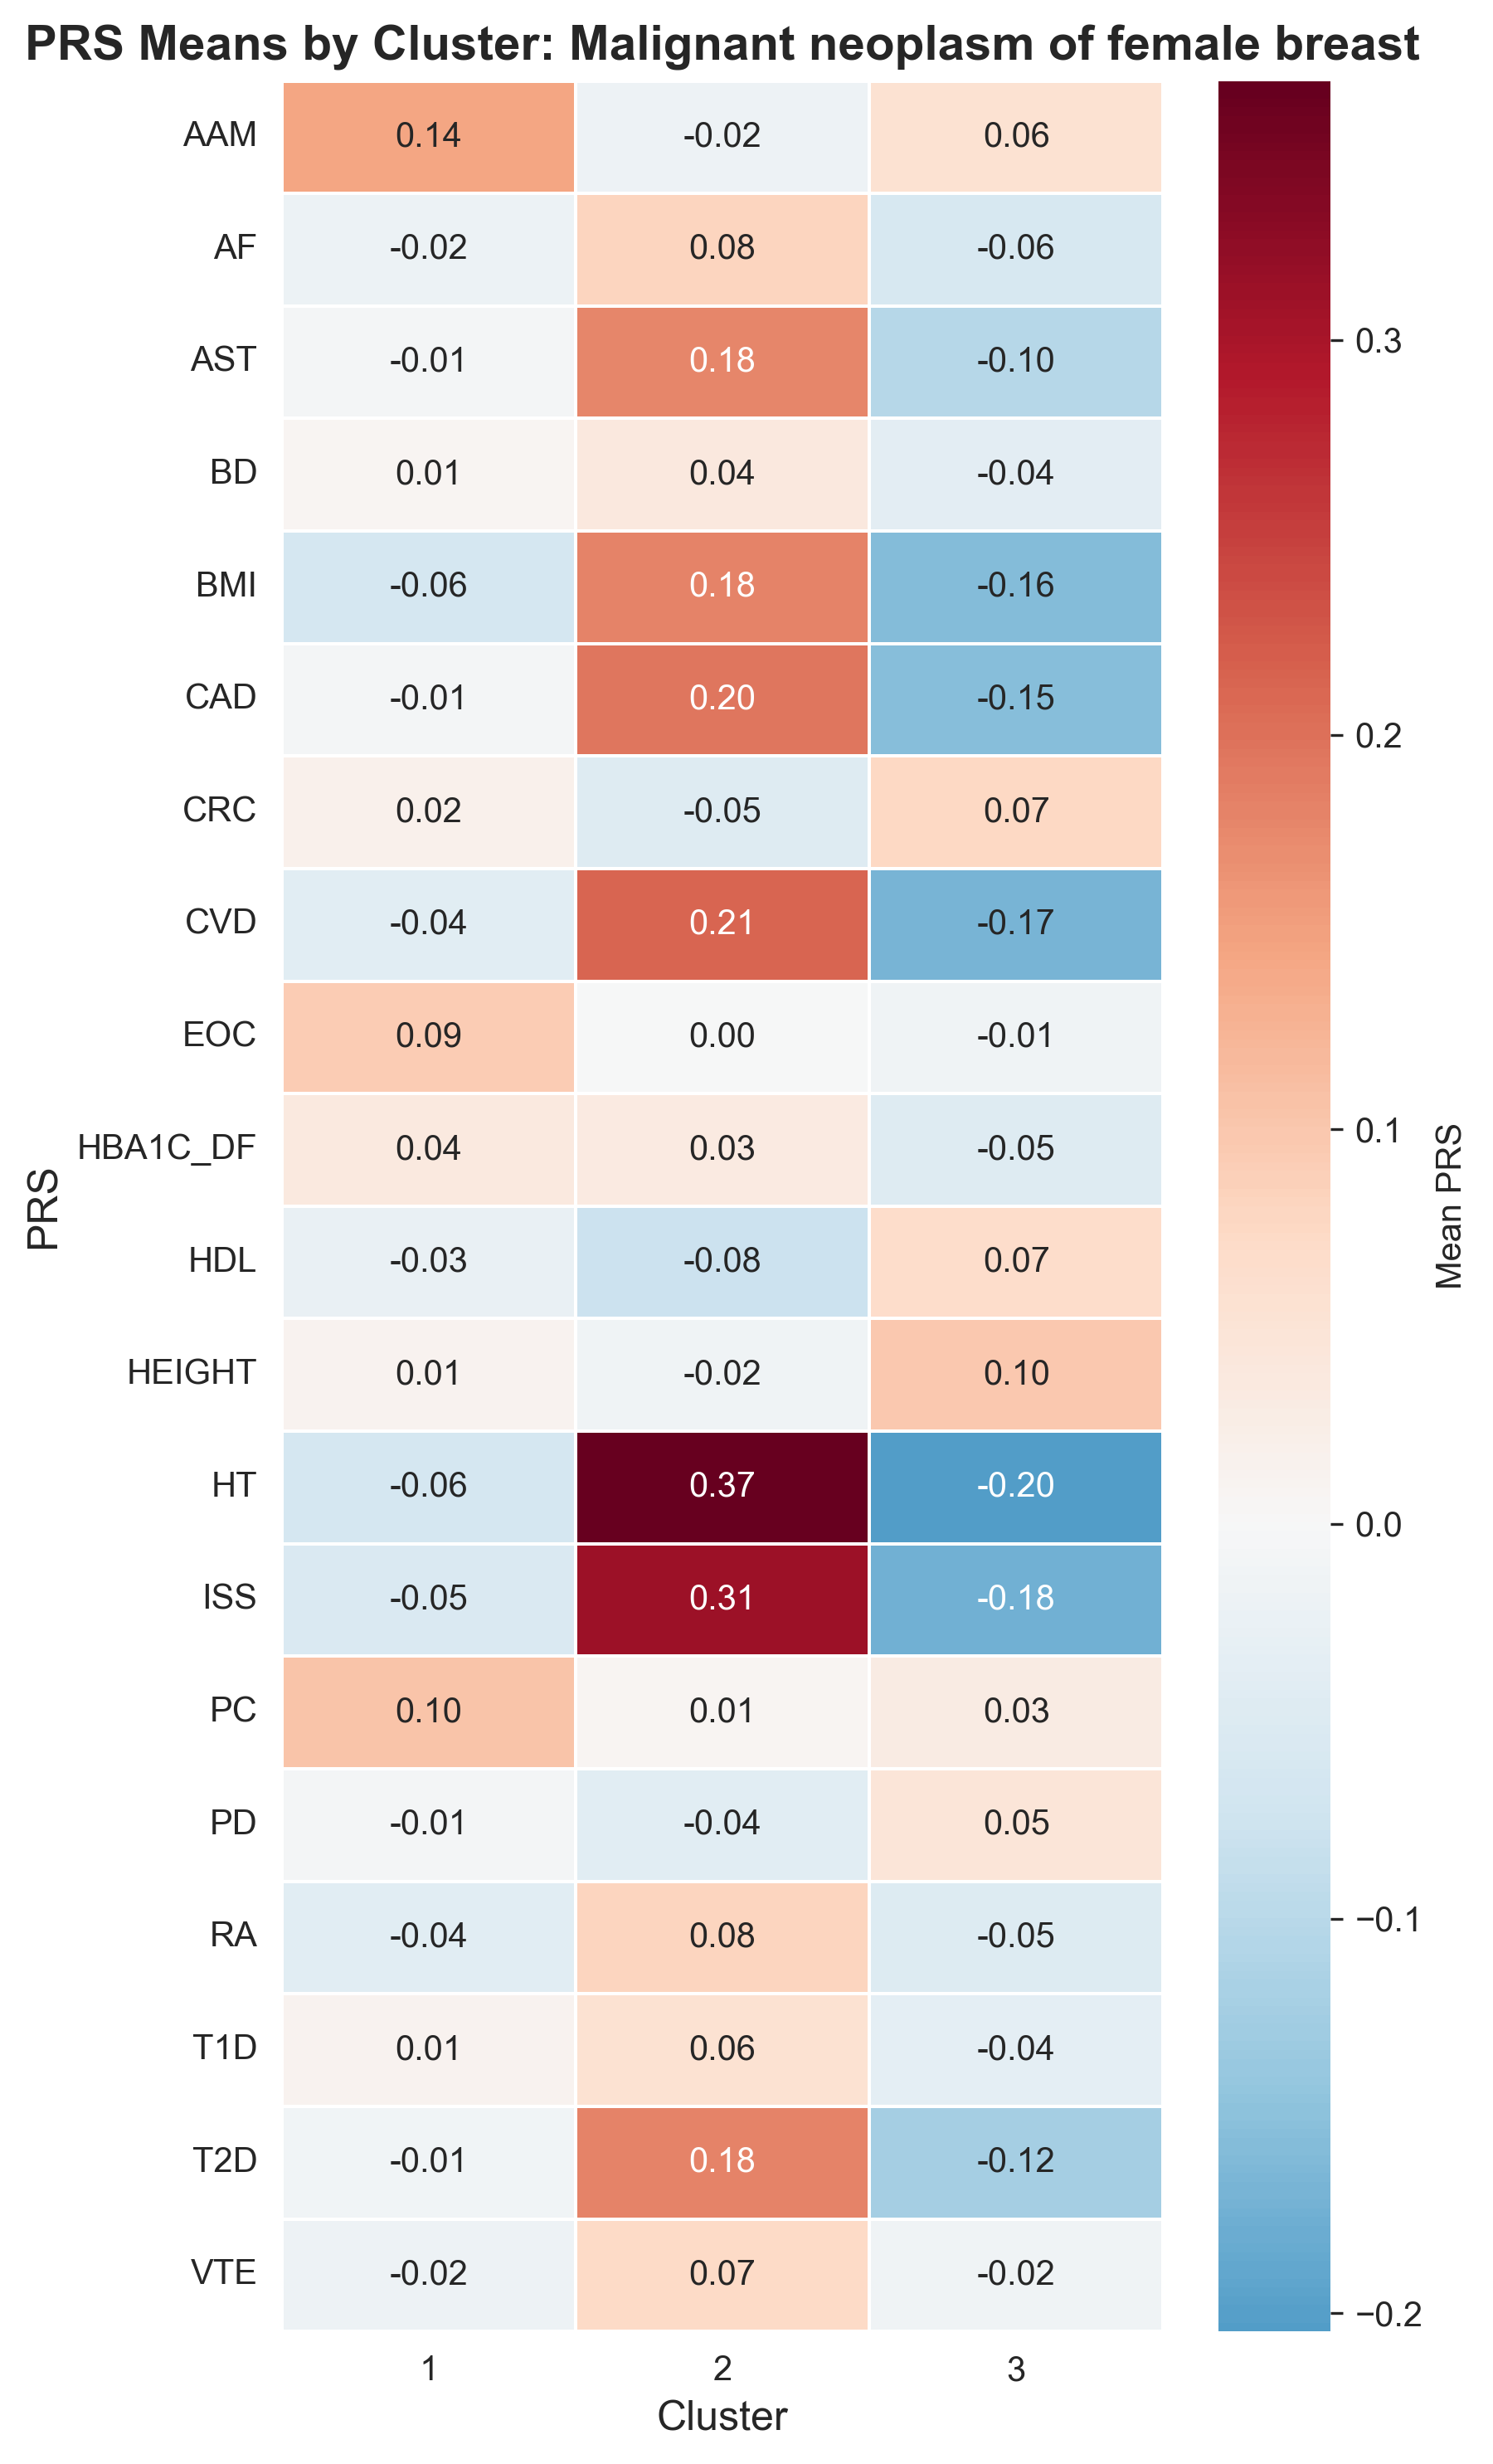

✅ Saved CSV: heterogeneity_main_paper_output/prs_cohens_d_Malignant_neoplasm_of_female_breast.csv

Creating PRS heatmap for: Major depressive disorder
✅ Saved: heterogeneity_main_paper_output/prs_means_Major_depressive_disorder.pdf


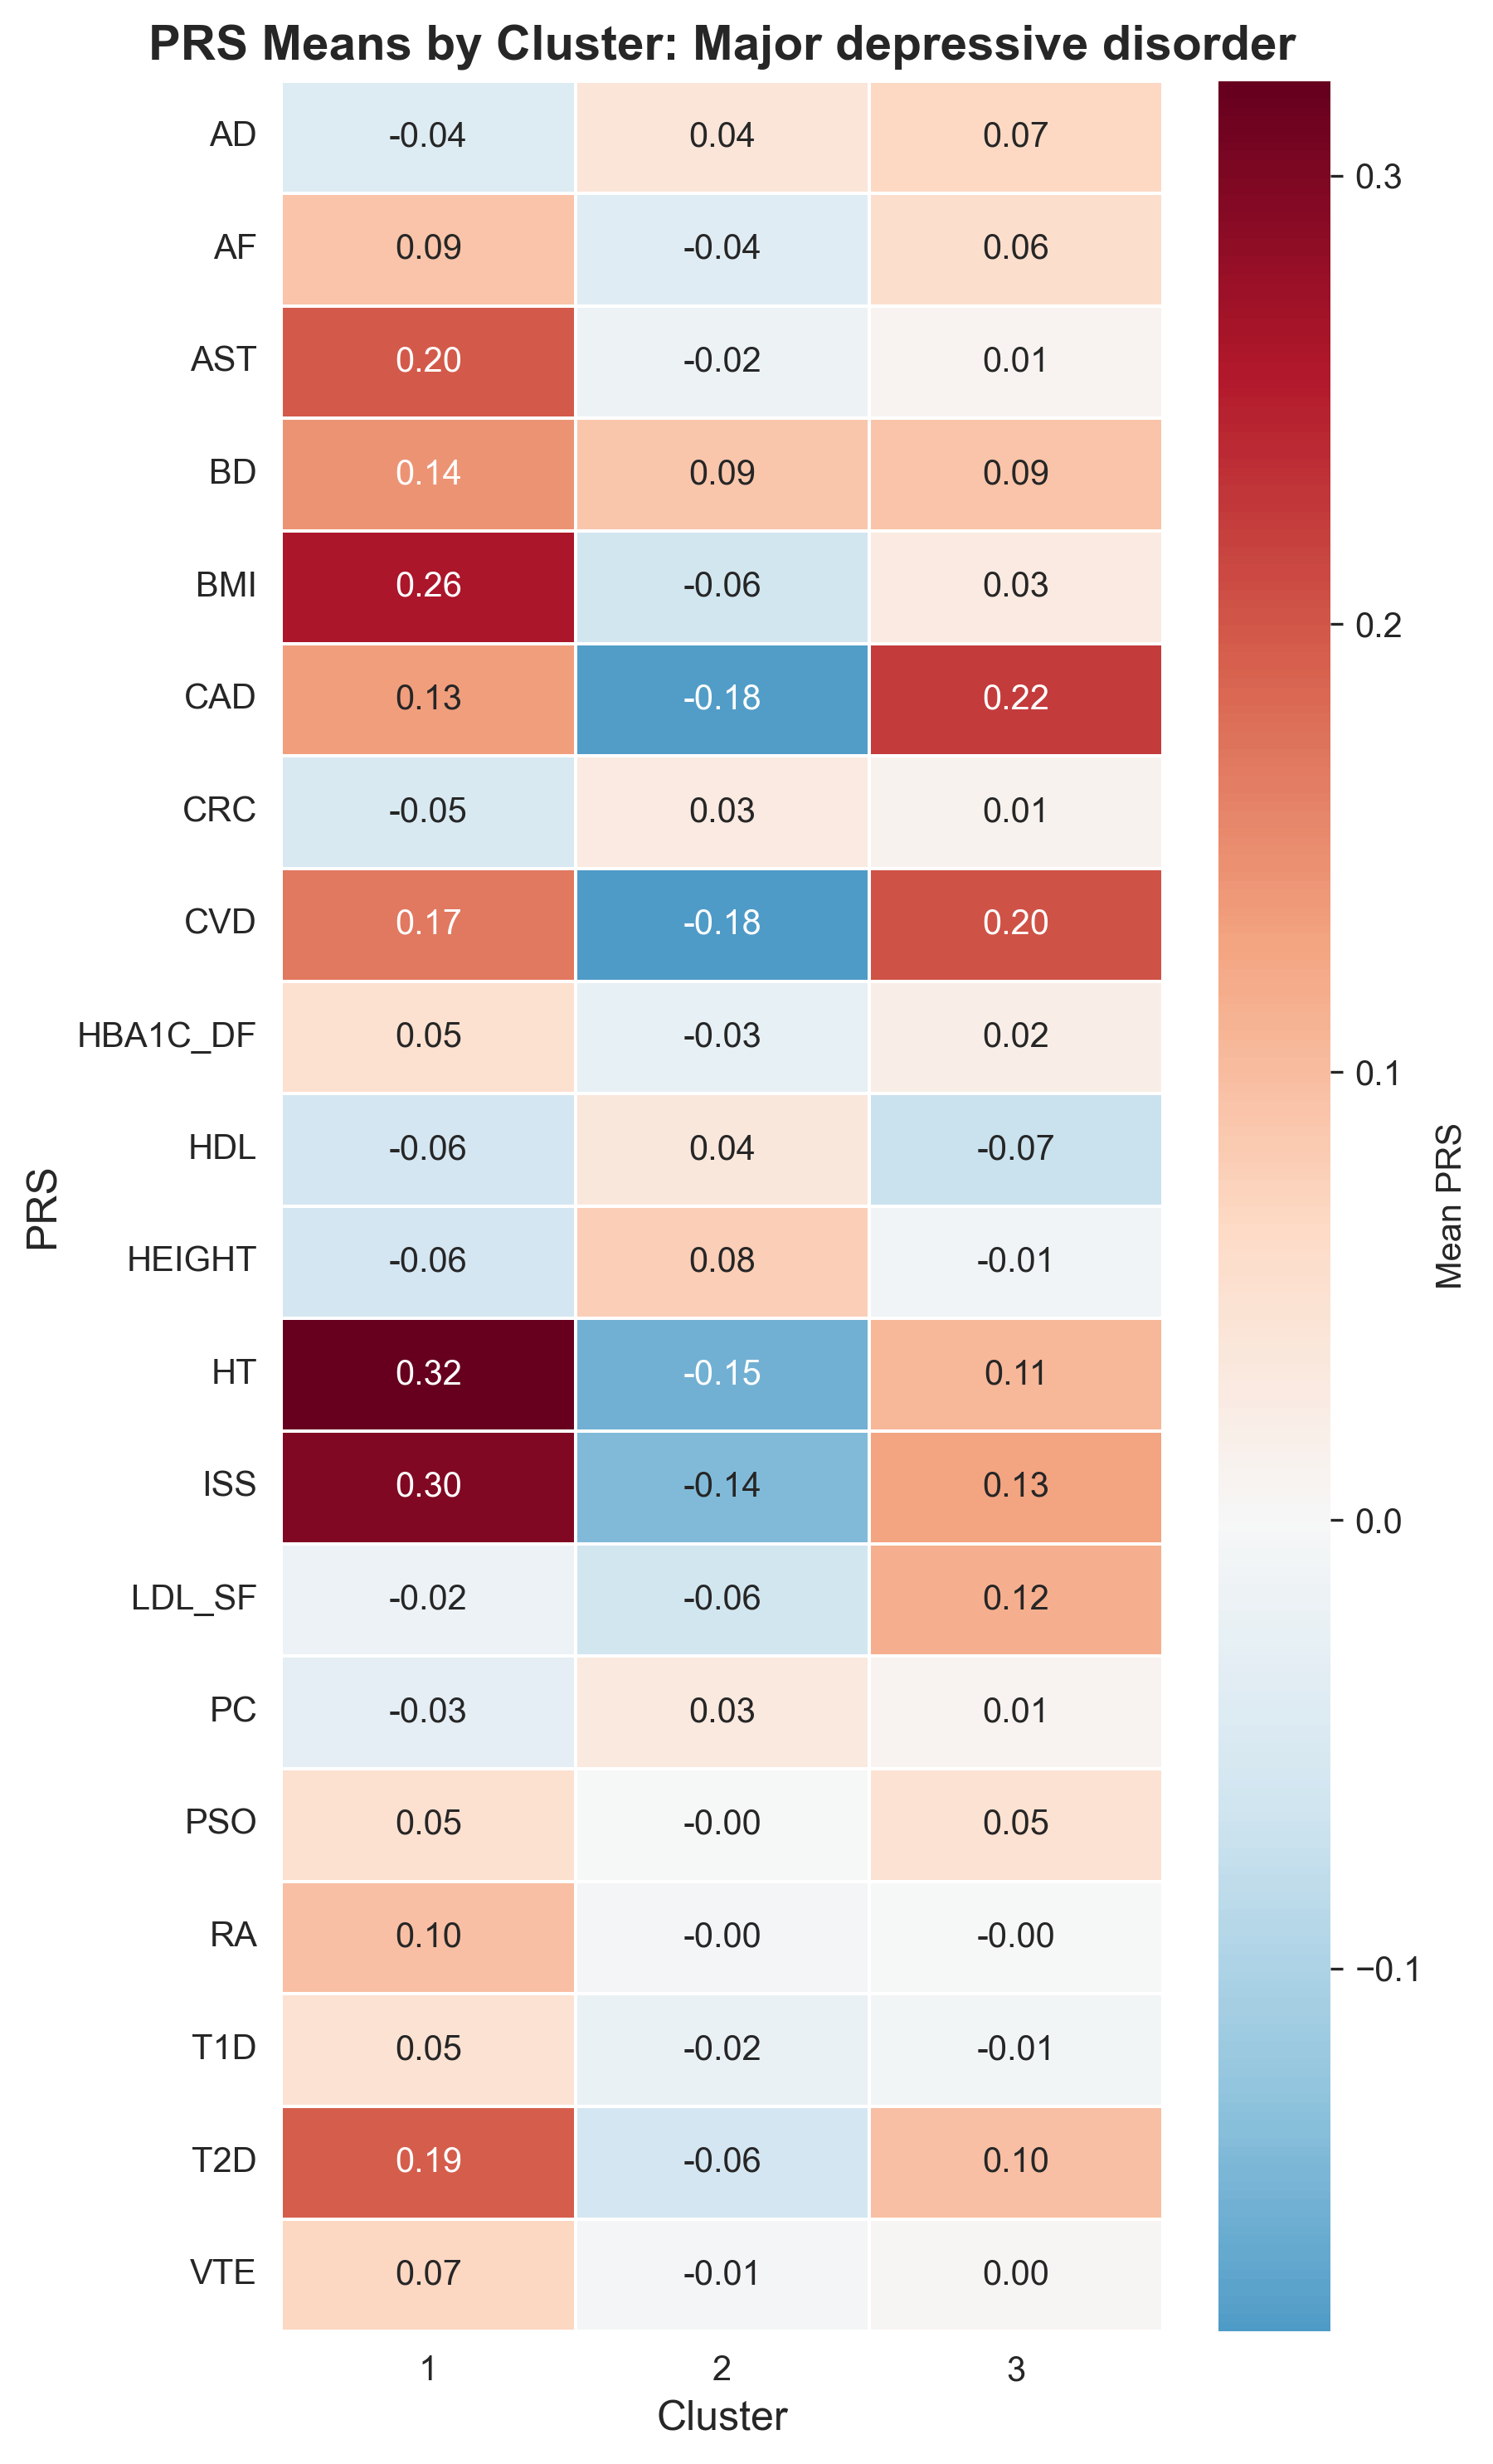

✅ Saved CSV: heterogeneity_main_paper_output/prs_cohens_d_Major_depressive_disorder.csv


In [7]:
# ============================================================================
# PLOT 3: PRS Heatmap by Cluster
# ============================================================================
# This replicates the PRS heatmap from trajectory_and_prs_cluster.R (p2)

for target_disease, results in results_dict.items():
    print(f"\n{'='*80}")
    print(f"Creating PRS heatmap for: {target_disease}")
    print(f"{'='*80}")
    
    clusters = results['clusters']
    prs_matrix = results['prs_matrix']
    prs_mask = results['prs_mask']
    n_clusters = results['n_clusters']
    
    # Calculate Cohen's d for PRS and create mean PRS matrix
    prs_cohens_d = []
    prs_means_list = []
    
    for c in range(n_clusters):
        in_cluster = (clusters == c) & prs_mask
        out_cluster = (clusters != c) & prs_mask
        
        for r, prs_name in enumerate(prs_cols):
            if in_cluster.sum() > 0 and out_cluster.sum() > 0:
                mean_in = prs_matrix[in_cluster, r].mean()
                mean_out = prs_matrix[out_cluster, r].mean()
                
                std_in = prs_matrix[in_cluster, r].std()
                std_out = prs_matrix[out_cluster, r].std()
                
                n_in = in_cluster.sum()
                n_out = out_cluster.sum()
                
                pooled_sd = np.sqrt(((n_in - 1) * std_in**2 + (n_out - 1) * std_out**2) / (n_in + n_out - 2))
                
                d = (mean_in - mean_out) / pooled_sd if pooled_sd > 0 else 0
                
                prs_cohens_d.append({
                    'Cluster': c + 1,
                    'PRS': prs_name,
                    'Mean_In': mean_in,
                    'Mean_Out': mean_out,
                    'Cohen_d': d
                })
                
                prs_means_list.append({
                    'Cluster': c + 1,
                    'PRS': prs_name,
                    'Mean': mean_in
                })
    
    prs_cohens_d_df = pd.DataFrame(prs_cohens_d)
    prs_means_df = pd.DataFrame(prs_means_list)
    
    # Get top PRS by absolute Cohen's d
    prs_summary = prs_cohens_d_df.groupby('PRS')['Cohen_d'].apply(lambda x: x.abs().max()).sort_values(ascending=False)
    top_prs = prs_summary.head(20).index.tolist()
    
    # Create heatmap for top PRS
    prs_subset = prs_means_df[prs_means_df['PRS'].isin(top_prs)]
    pivot_prs = prs_subset.pivot_table(
        index='PRS',
        columns='Cluster',
        values='Mean',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(6, 10))
    
    sns.heatmap(
        pivot_prs,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        cbar_kws={'label': 'Mean PRS'},
        ax=ax,
        linewidths=0.5
    )
    
    ax.set_title(
        f'PRS Means by Cluster: {target_disease}',
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('PRS', fontsize=12)
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, f'prs_means_{target_disease.replace(" ", "_")}.pdf')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")
    plt.show()
    
    # Save results
    csv_path = os.path.join(output_dir, f'prs_cohens_d_{target_disease.replace(" ", "_")}.csv')
    prs_cohens_d_df.to_csv(csv_path, index=False)
    print(f"✅ Saved CSV: {csv_path}")


## Summary

This notebook replicates the main paper's heterogeneity method with all visualizations:

1. **Clustering**: Patients clustered by time-averaged signature loadings (k-means, k=3)
2. **Deviations**: Stacked area plot showing how each cluster deviates from population reference over time
3. **Signature Analysis**: Heatmap of Cohen's d for signatures by cluster
4. **PRS Correlation**: Heatmap of mean PRS by cluster

**Key Difference from Deviation-Based Method:**
- **This method (main paper)**: Clusters first on average loadings, then visualizes deviations (more interpretable for clinical stratification)
- **Deviation-based method** (R3_Q8_Heterogeneity_Continued): Clusters by deviations directly (better for pathway discovery)

Both approaches demonstrate heterogeneity, but serve different purposes.

**Output files saved to:** `heterogeneity_main_paper_output/`
